In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np

import rtgp.bayesian_optimisation as bayesian_optimisation
import gpflow

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
%matplotlib inline


In [2]:
def plot_bo(bo, acq_function, X, Y, bounds, title = None):
    # Plot optimization objective with noise level 
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex = True)

    if bo.gp_kind == 'standard':
        gp_color = CB_color_cycle[2]
    if bo.gp_kind == 'robust':
        gp_color = CB_color_cycle[0]

    if title:
        ax[0].set_title(title)

    ax[0].set_xlim(bounds[0,0], bounds[0,1])
    ax[1].set_xlim(bounds[0,0], bounds[0,1])
    
    ax[0].plot(X, Y, 'k--', lw=2, label='Objective')
    f_mean, f_var = bo.gp.predict_f(X, full_cov=False)

    f_std = np.sqrt(f_var)
    ax[0].plot(X[:,0], f_mean, c=gp_color, lw=4, label= '{} GP Prediction'.format(bo.gp_kind), zorder =0)
    ax[0].fill_between(
        X[:,0],
        f_mean[:,0] - 1.96 * f_std[:,0],
        f_mean[:,0] + 1.96 * f_std[:,0],
        facecolor=  gp_color,
        alpha=0.5,
        label='95% IC')
    ax[0].scatter(bo.X_sample, bo.Y_sample, c='k', zorder=10, label = 'Observations')
    ax[0].scatter(bo.X_next[0,0], bo.Y_next[0,0],s = 100, c='red', marker = '*', zorder = 10, label = 'Next Best Guests')
    ax[1].plot(X[:,0], acq_function(X, bo.X_sample, bo.Y_sample, bo.gp), 'k', label = 'Acquisition Function')
    ax[1].scatter(bo.X_next[0,0], acq_function(bo.X_next, bo.X_sample, bo.Y_sample, bo.gp)[0,0], s=100, c='red', marker = '*', zorder = 10)
    fig.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1, edgecolor='k')
    fig.tight_layout()

In [3]:
bounds = np.array([[-2.0, 10.0]])


def f(X):
    return np.exp(-(X - 2)**2) + np.exp(-(X - 6)**2/10) + 1/ (X**2 + 1)

In [4]:
def f_outliers(X, eps=0.1):
    if np.random.random()<eps:
        print('outlier')
        return f(X) + np.random.normal()
    else:
        return f(X)

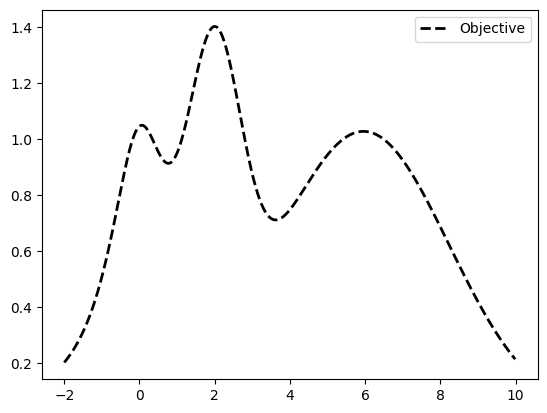

In [5]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X)
# Plot optimization objective with noise level 
plt.plot(X, Y, 'k--', lw=2, label='Objective')
plt.legend();


In [6]:
n_iter = 20

In [7]:
acq_function = bayesian_optimisation.AcquisitionFunction(kind="ei", kappa=5)
kernel = gpflow.kernels.SquaredExponential()

2023-09-07 10:42:53.679705: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


outlier
outlier
outlier


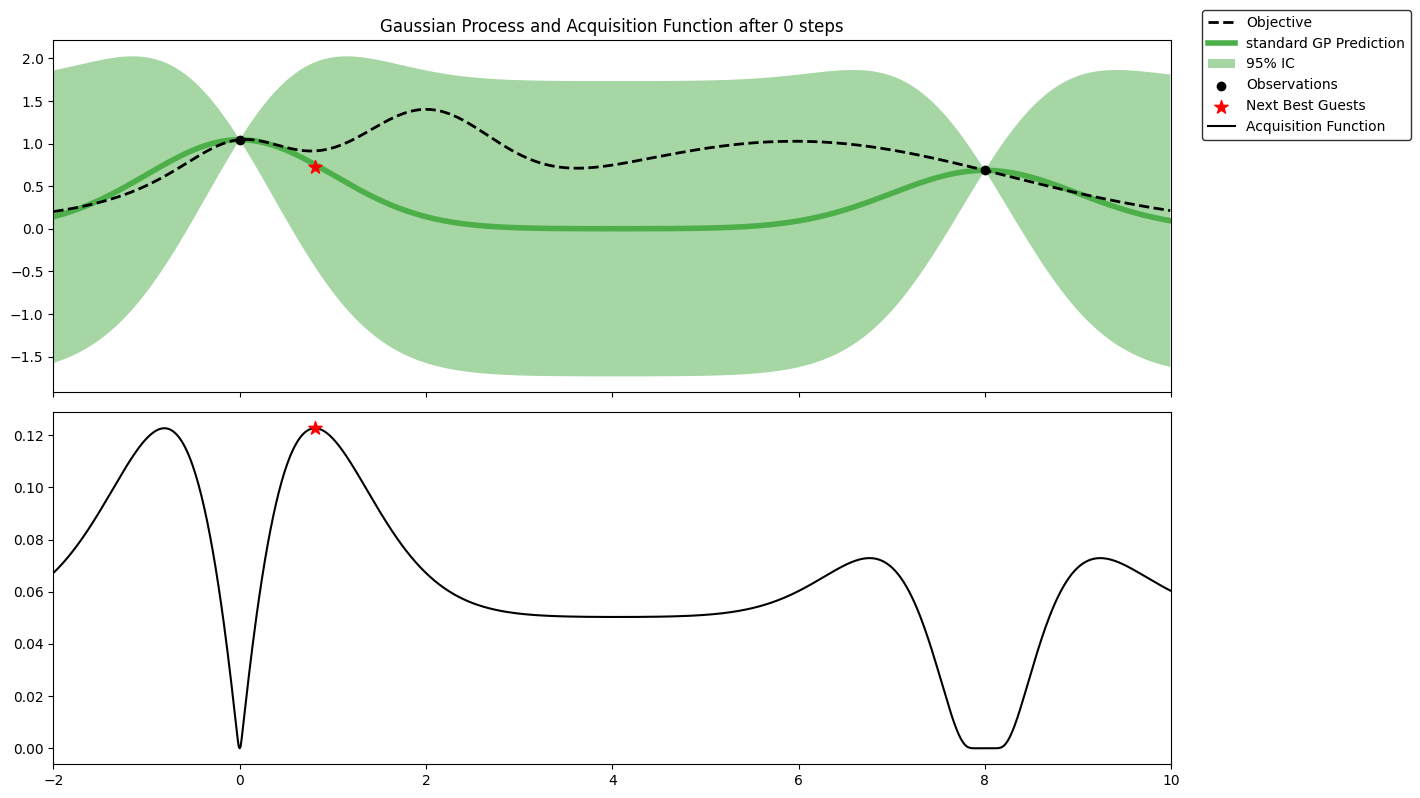

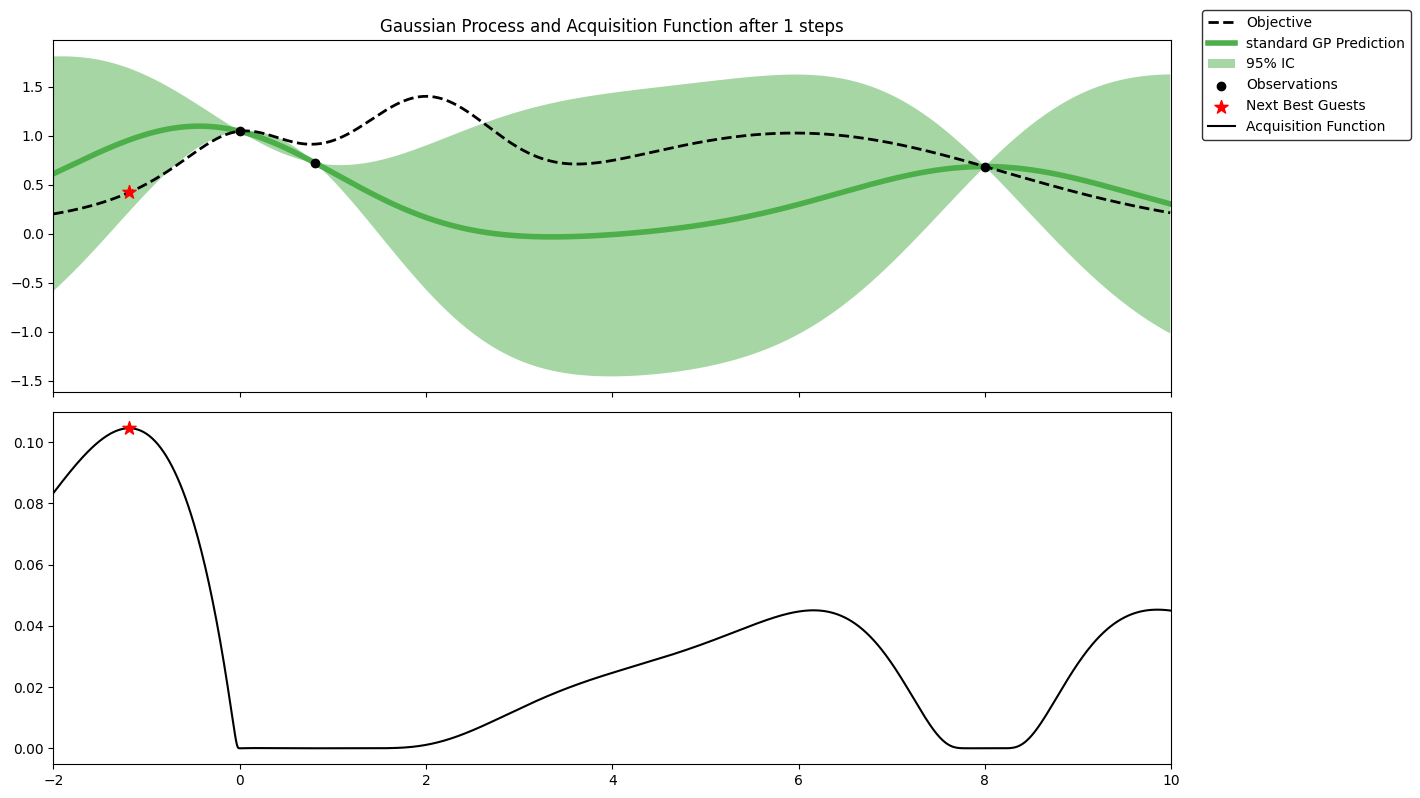

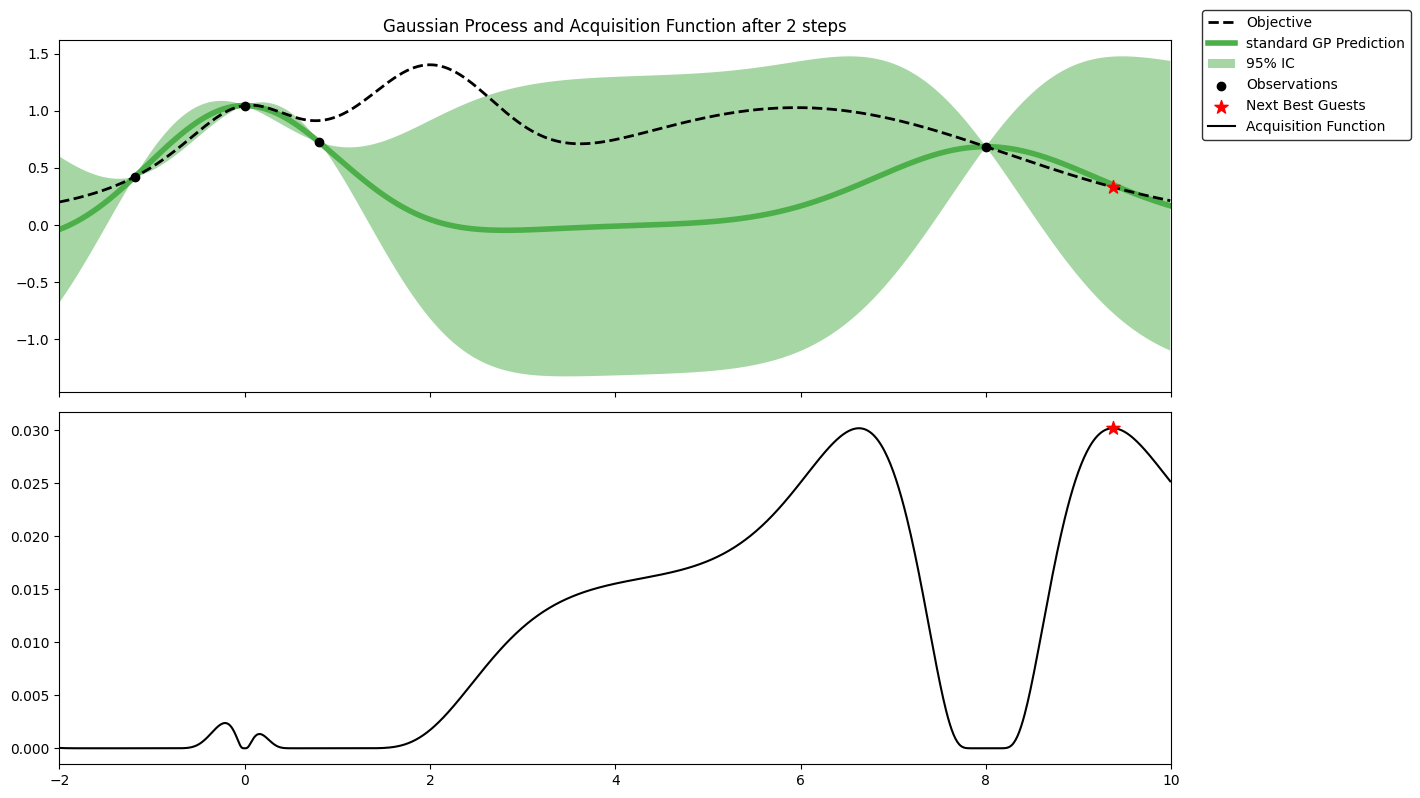

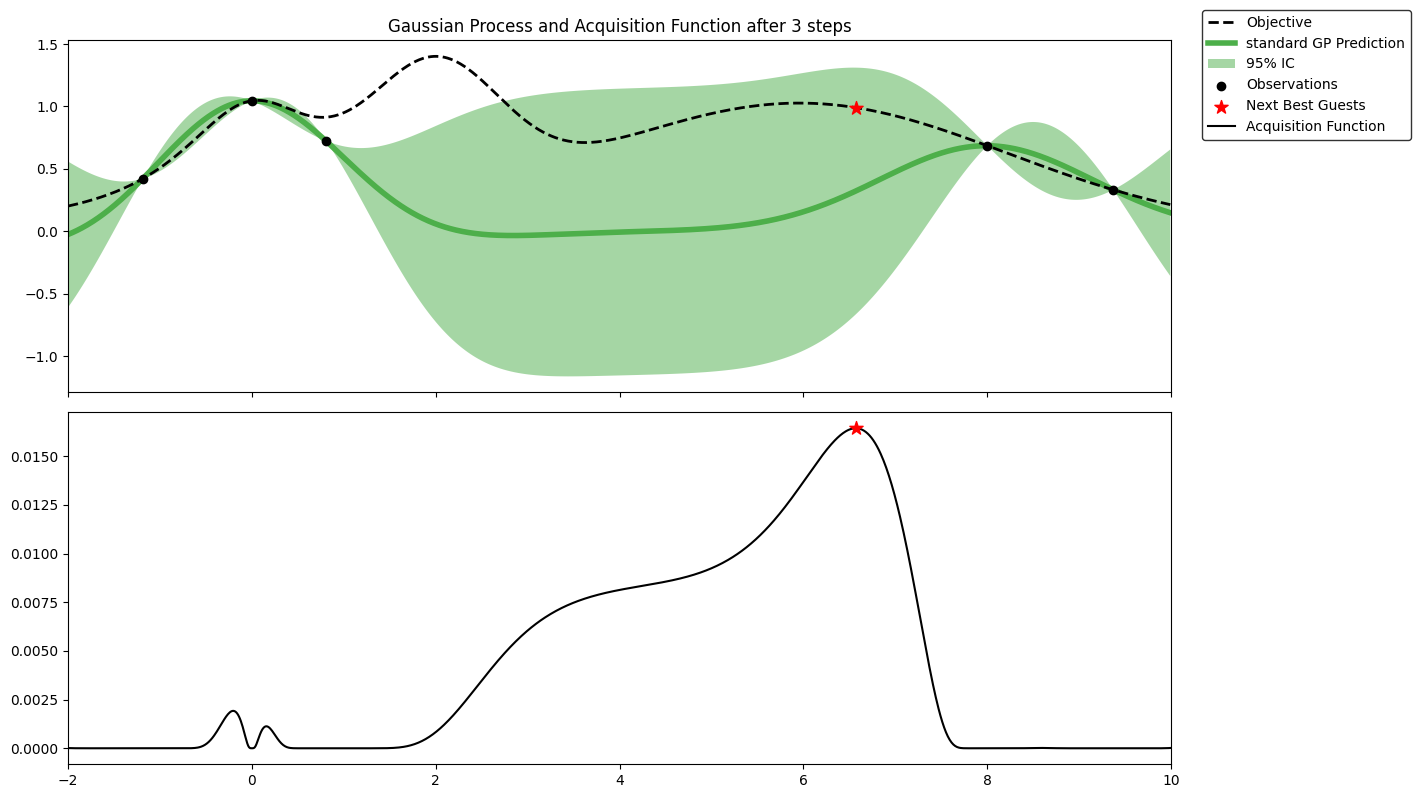

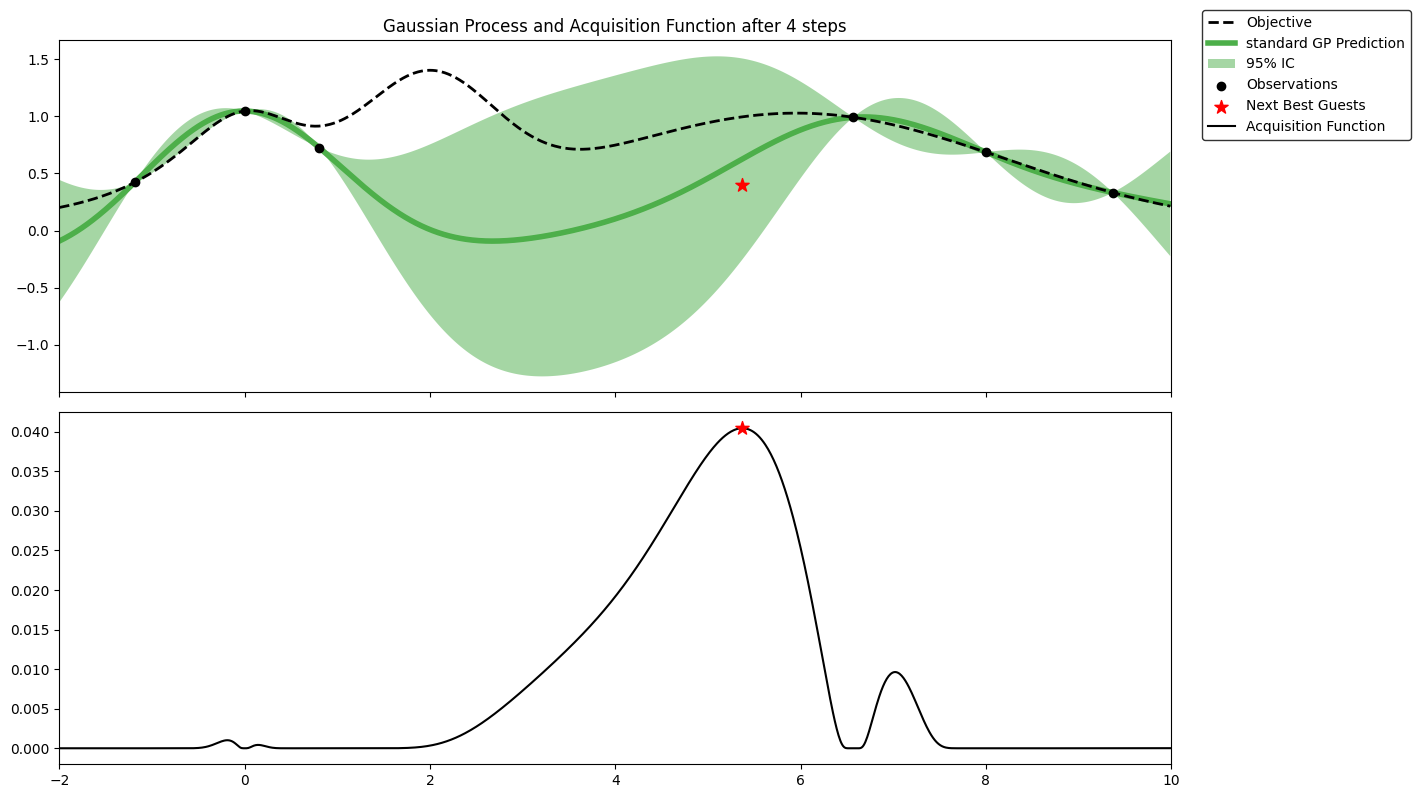

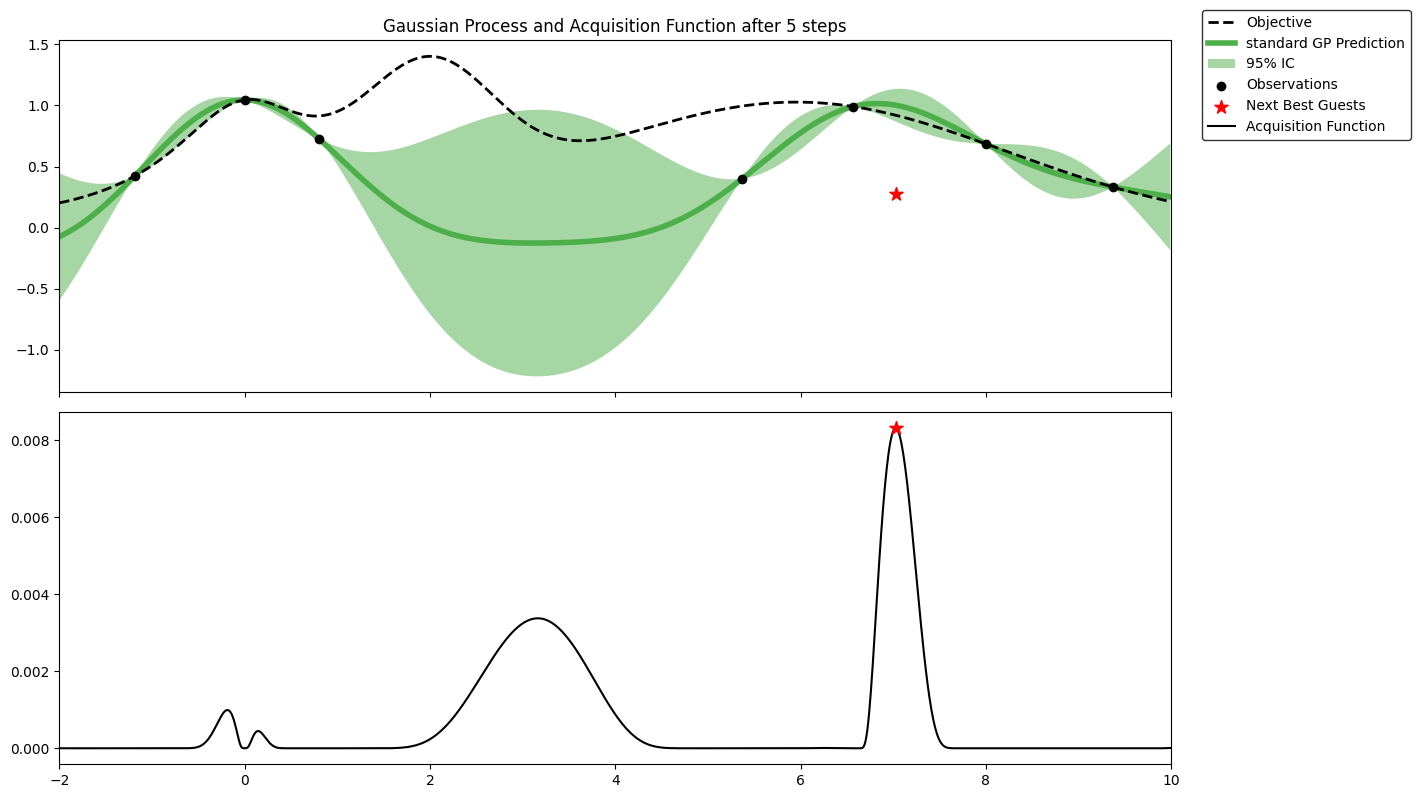

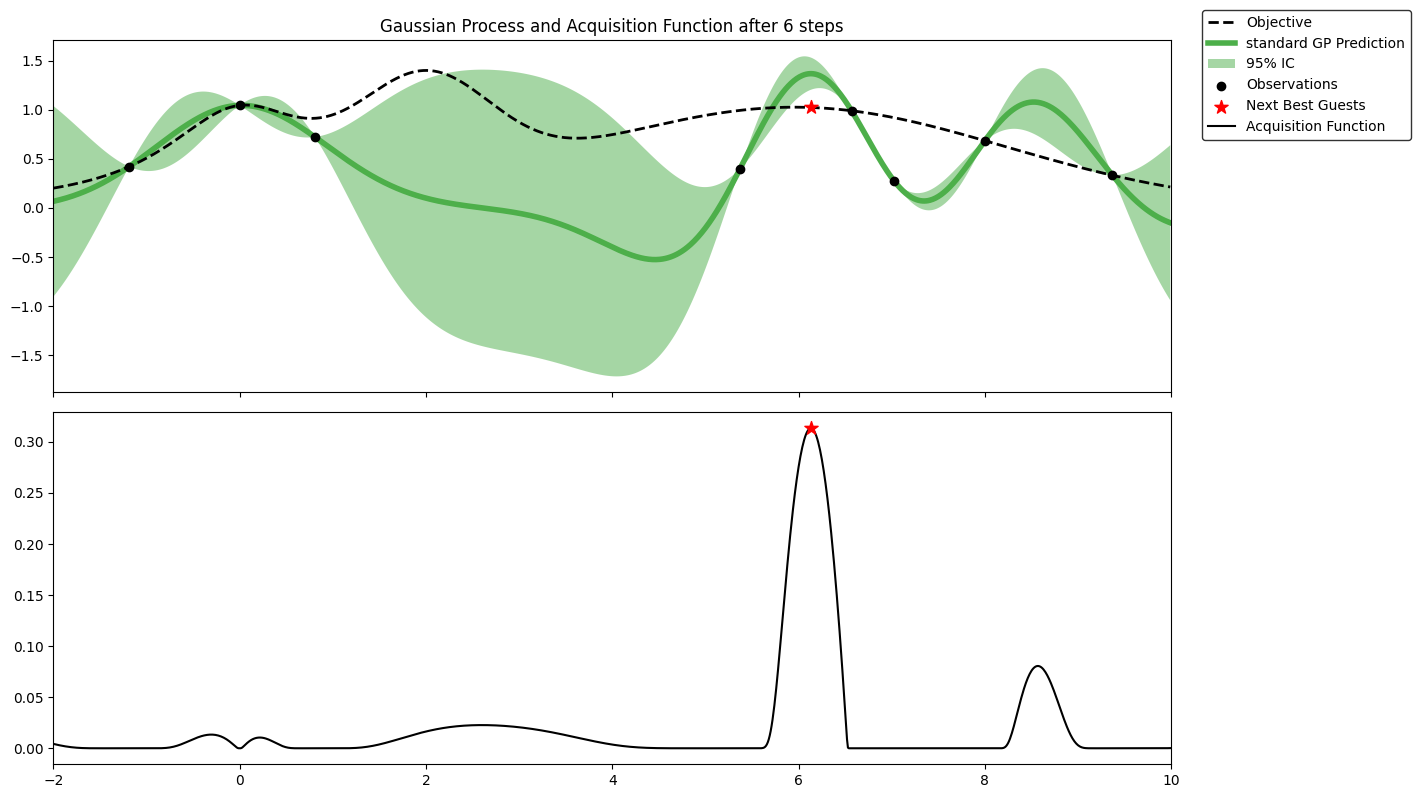

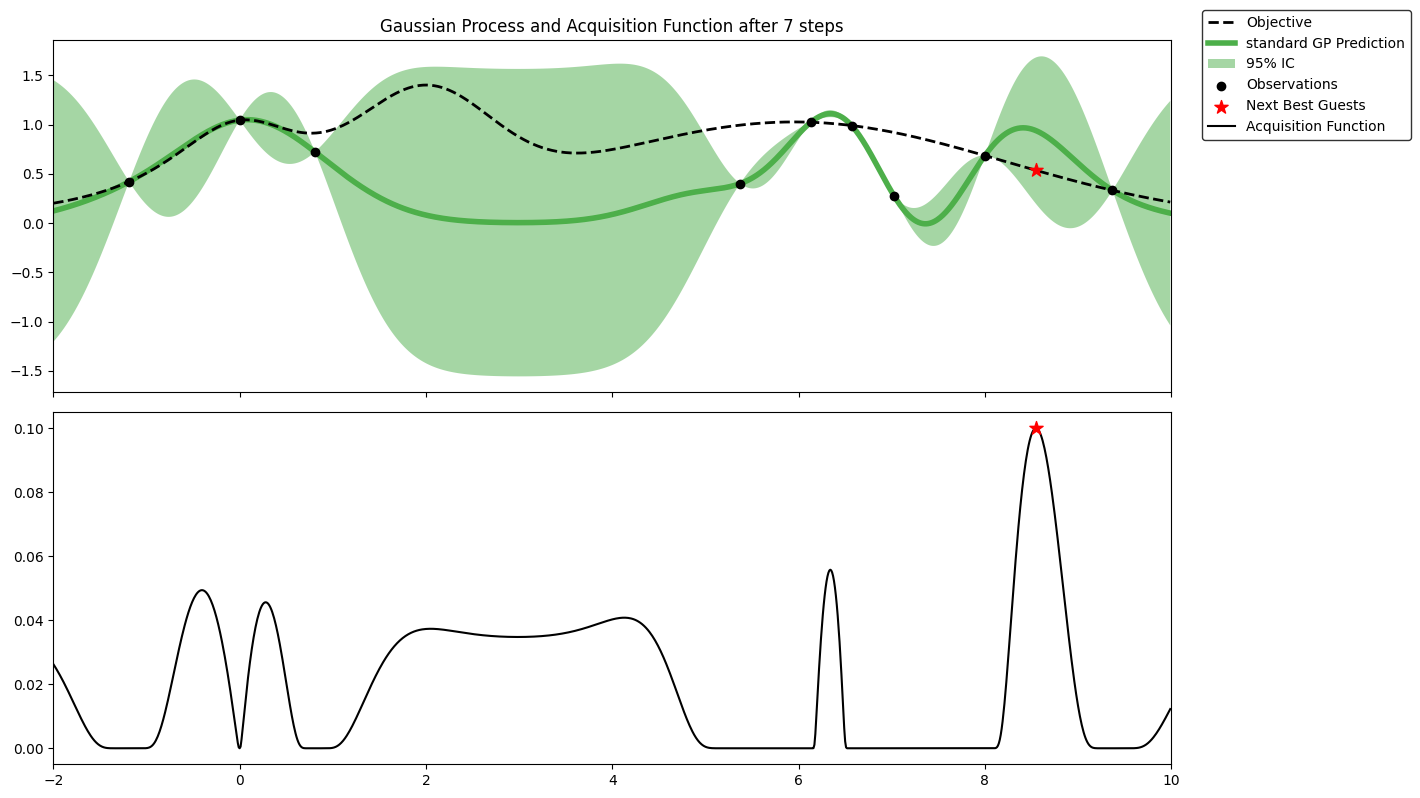

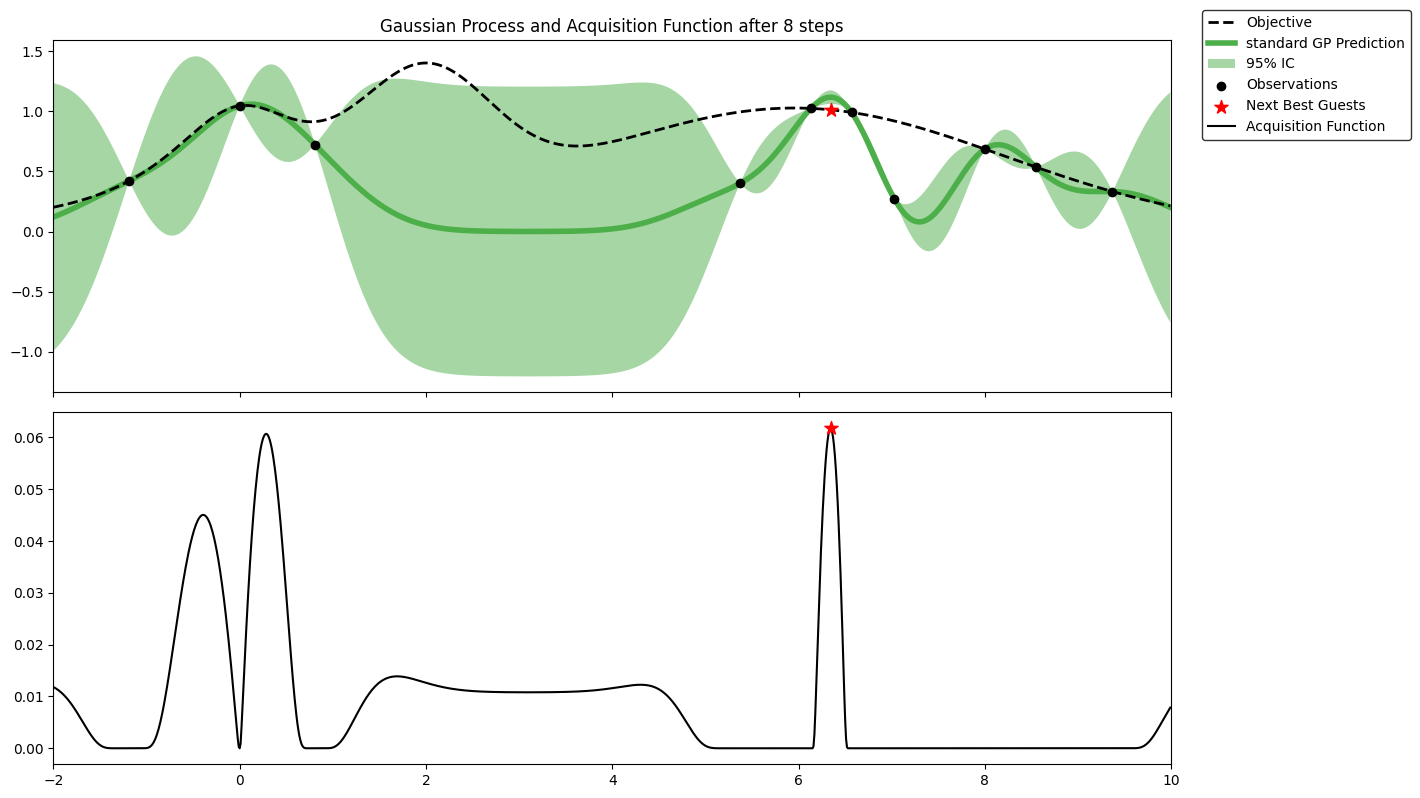

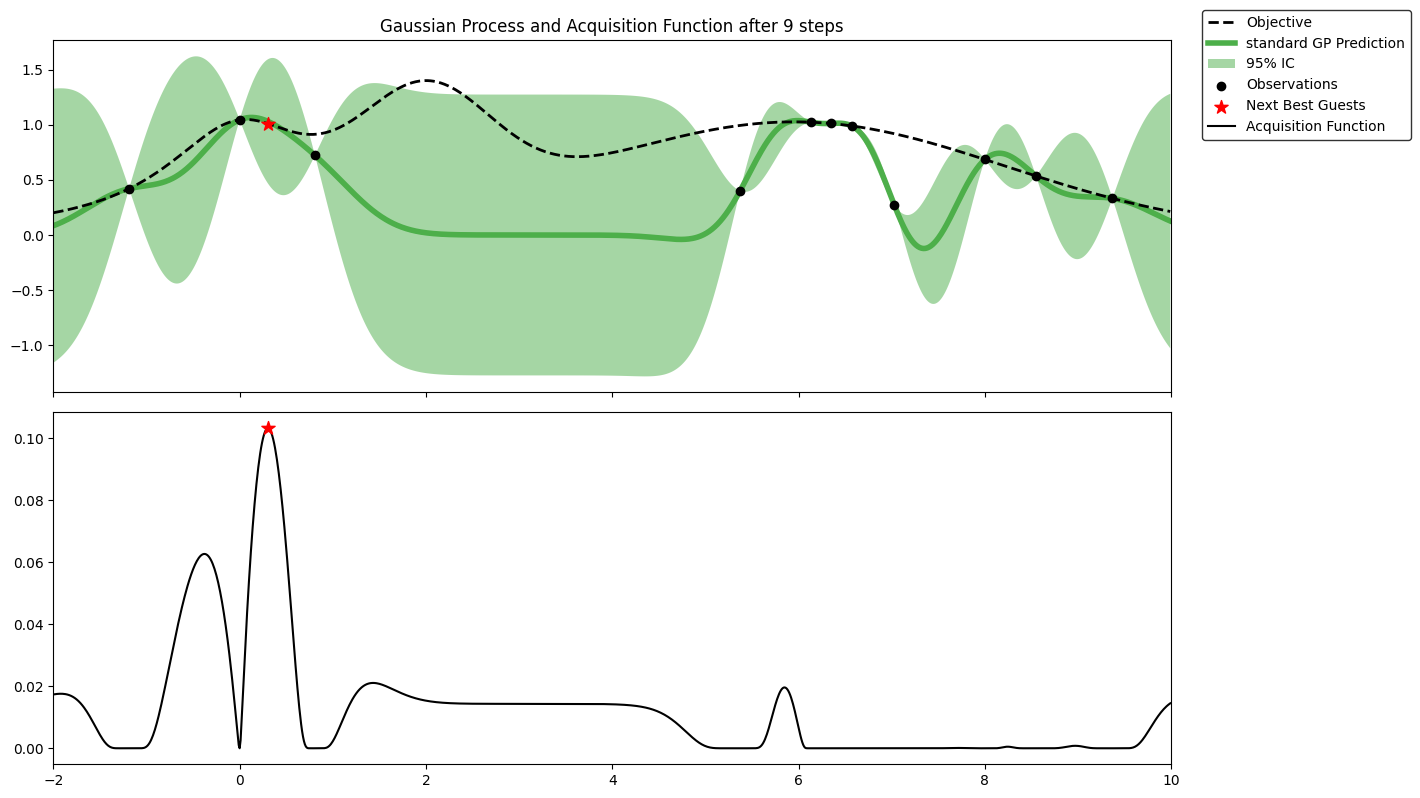

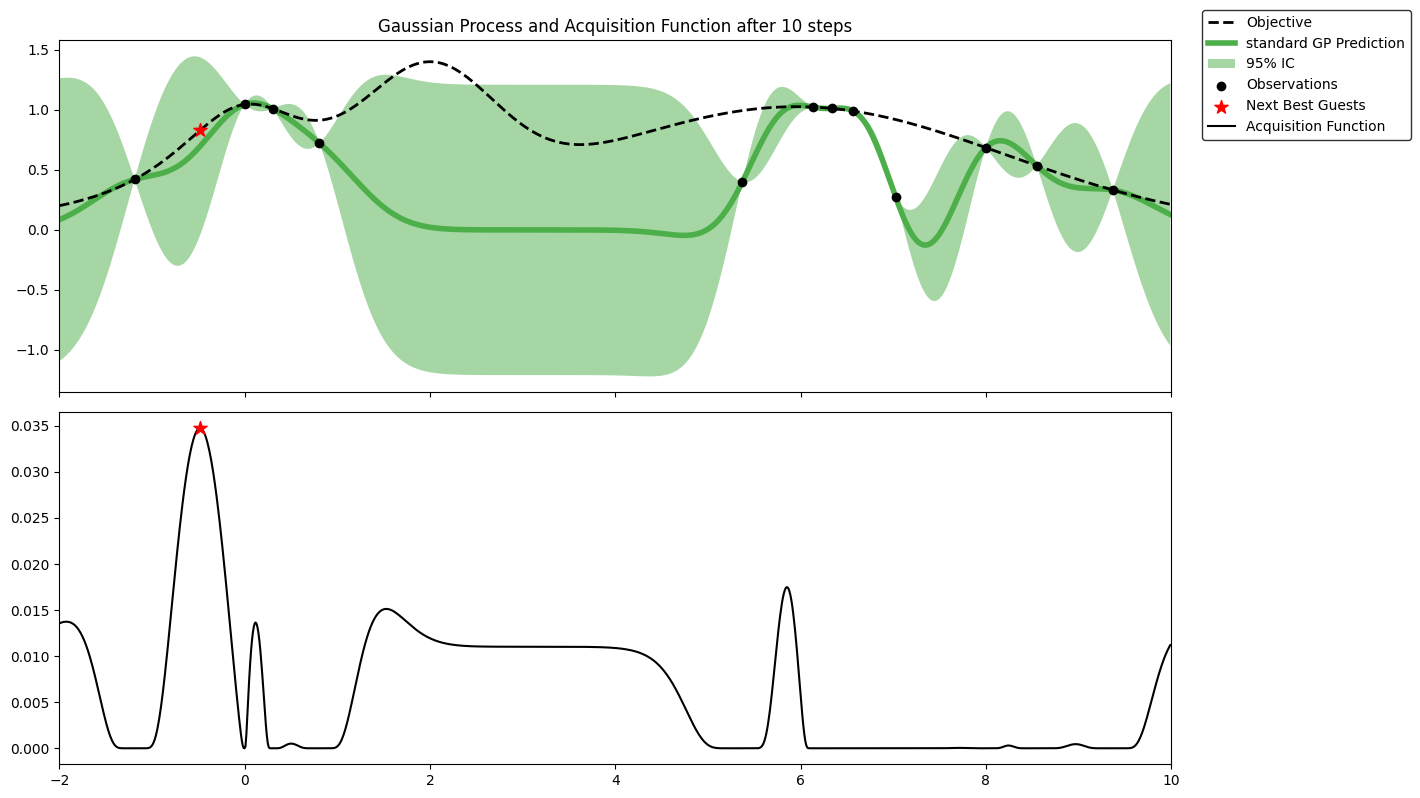

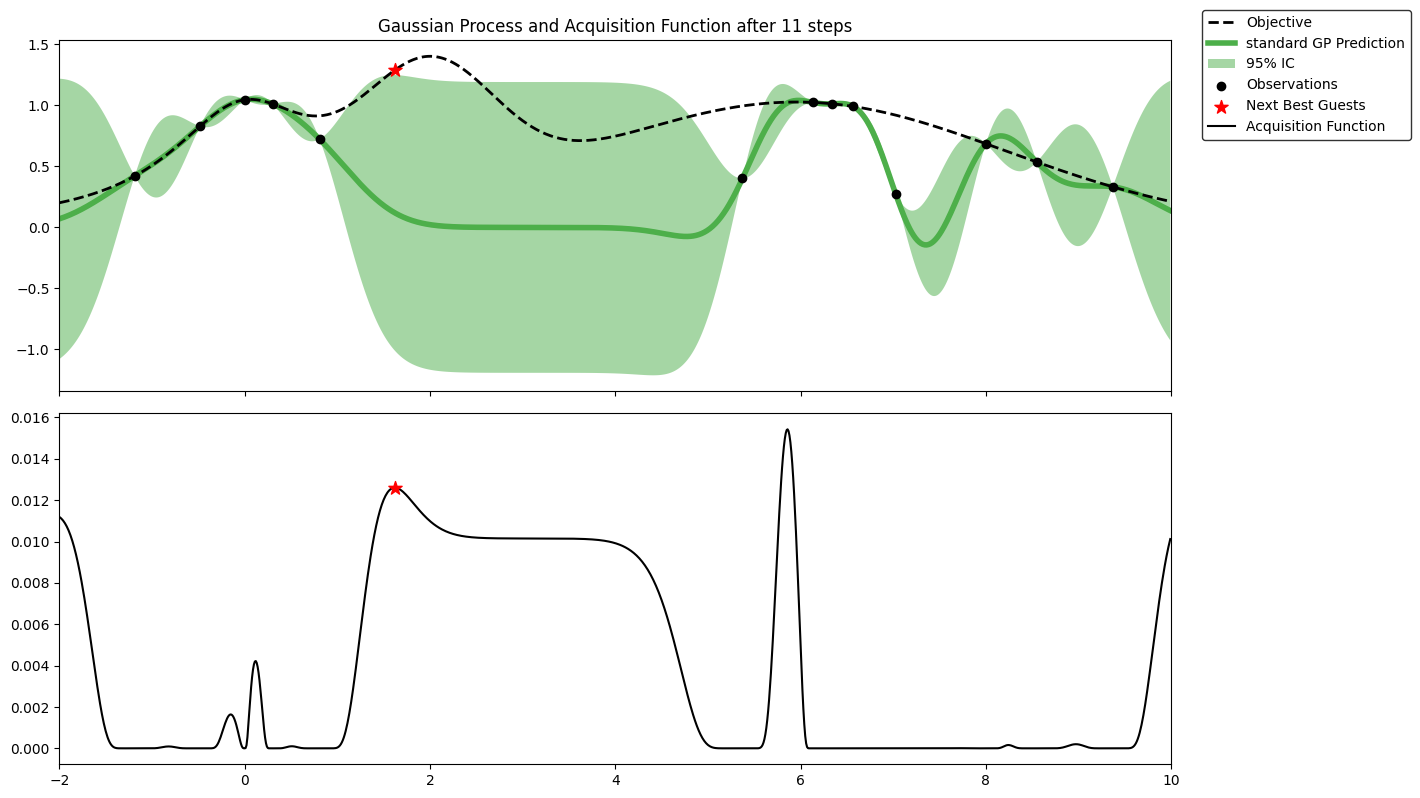

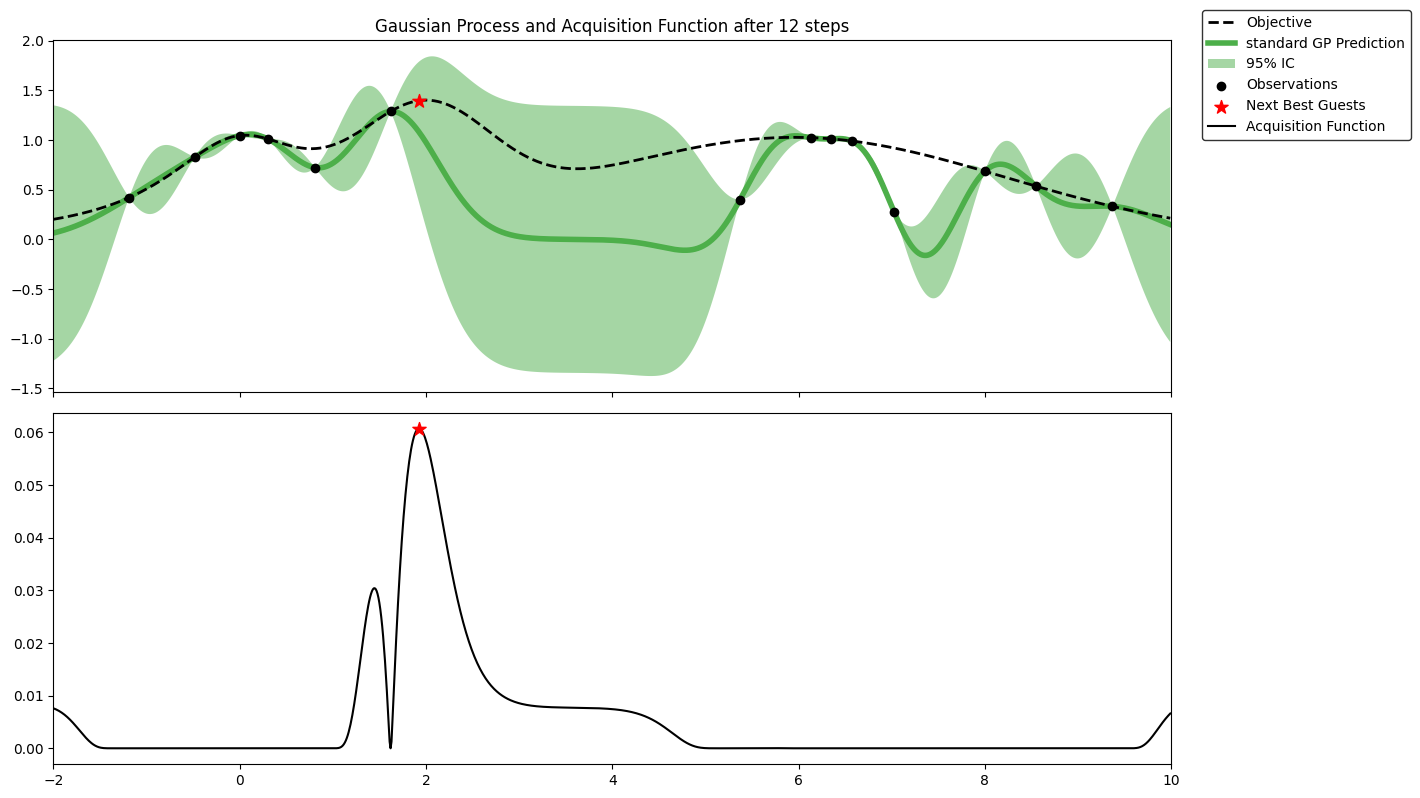

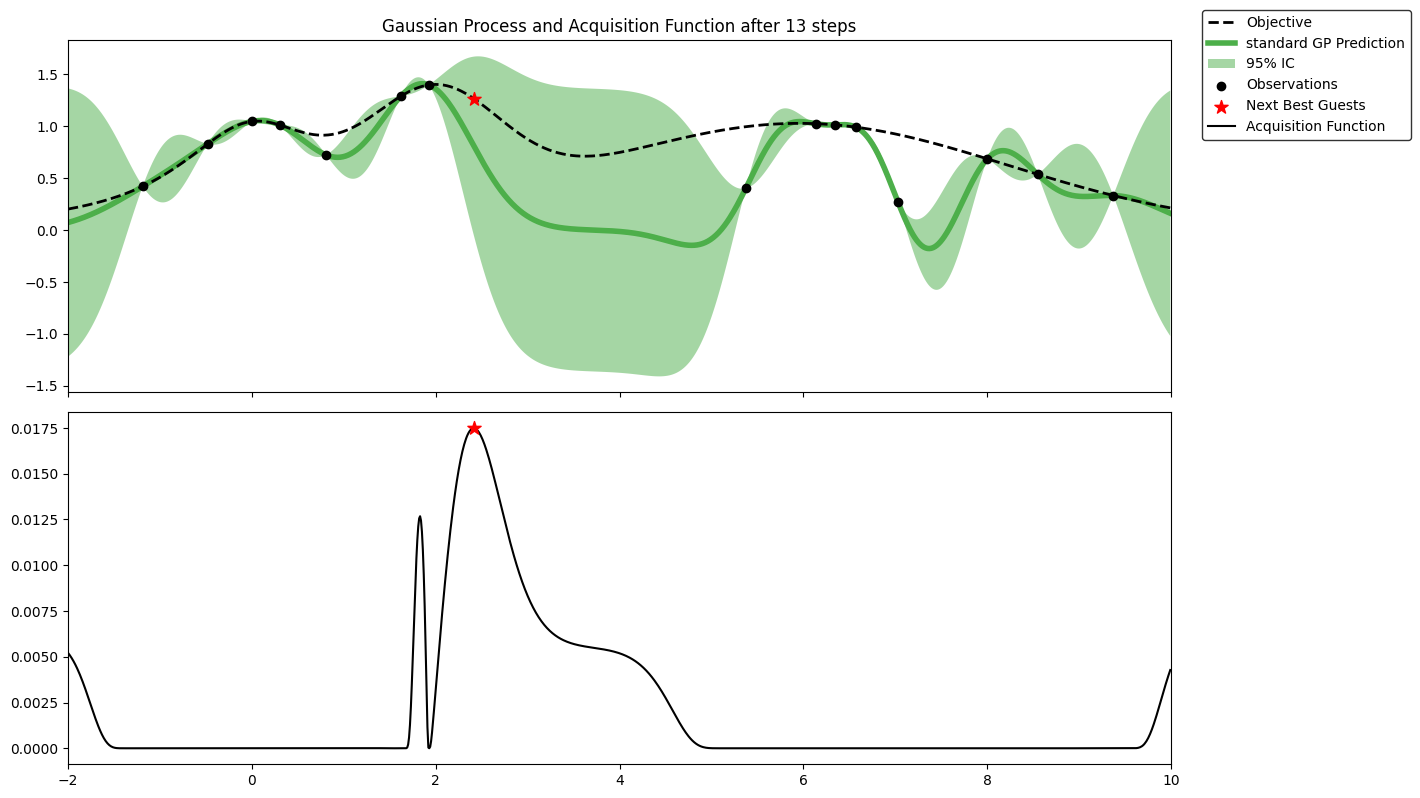

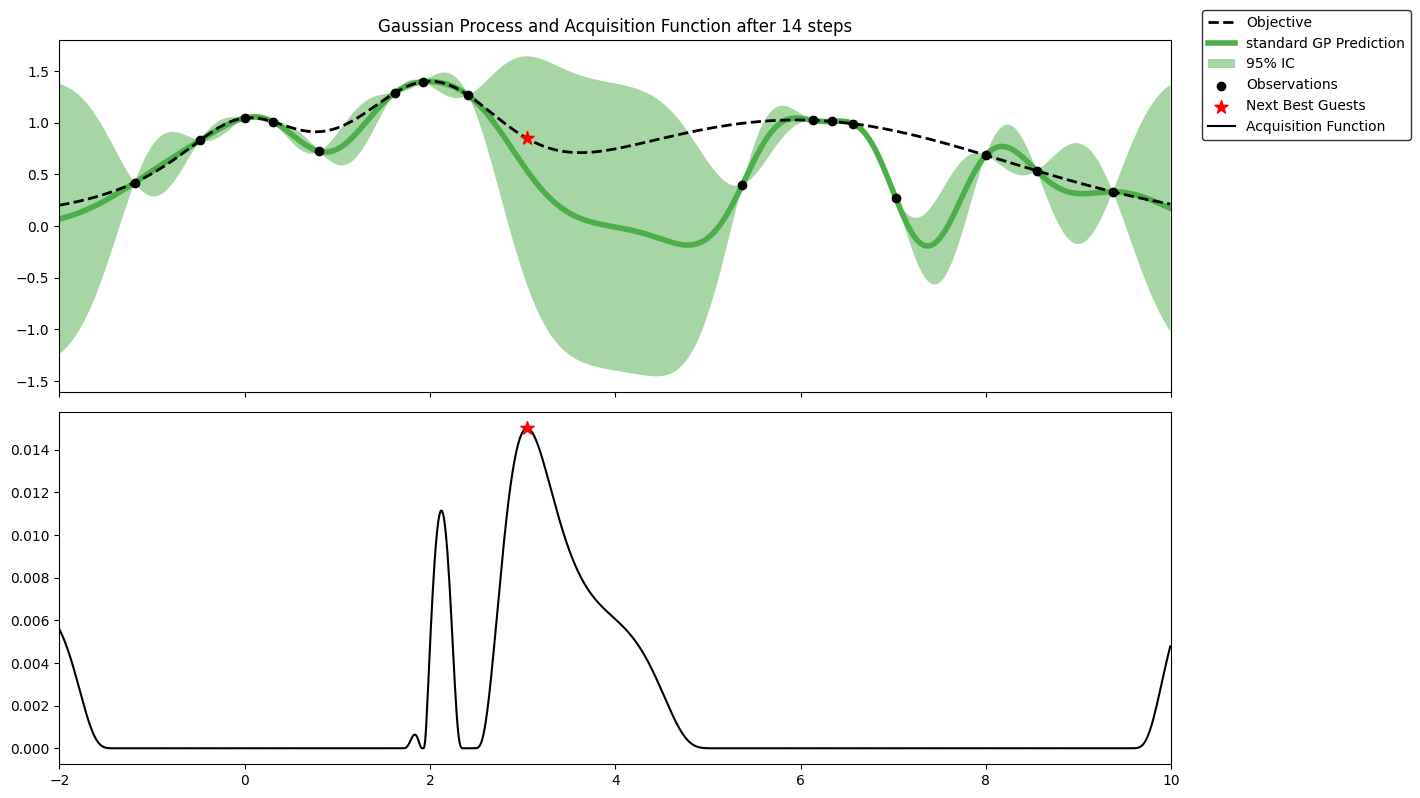

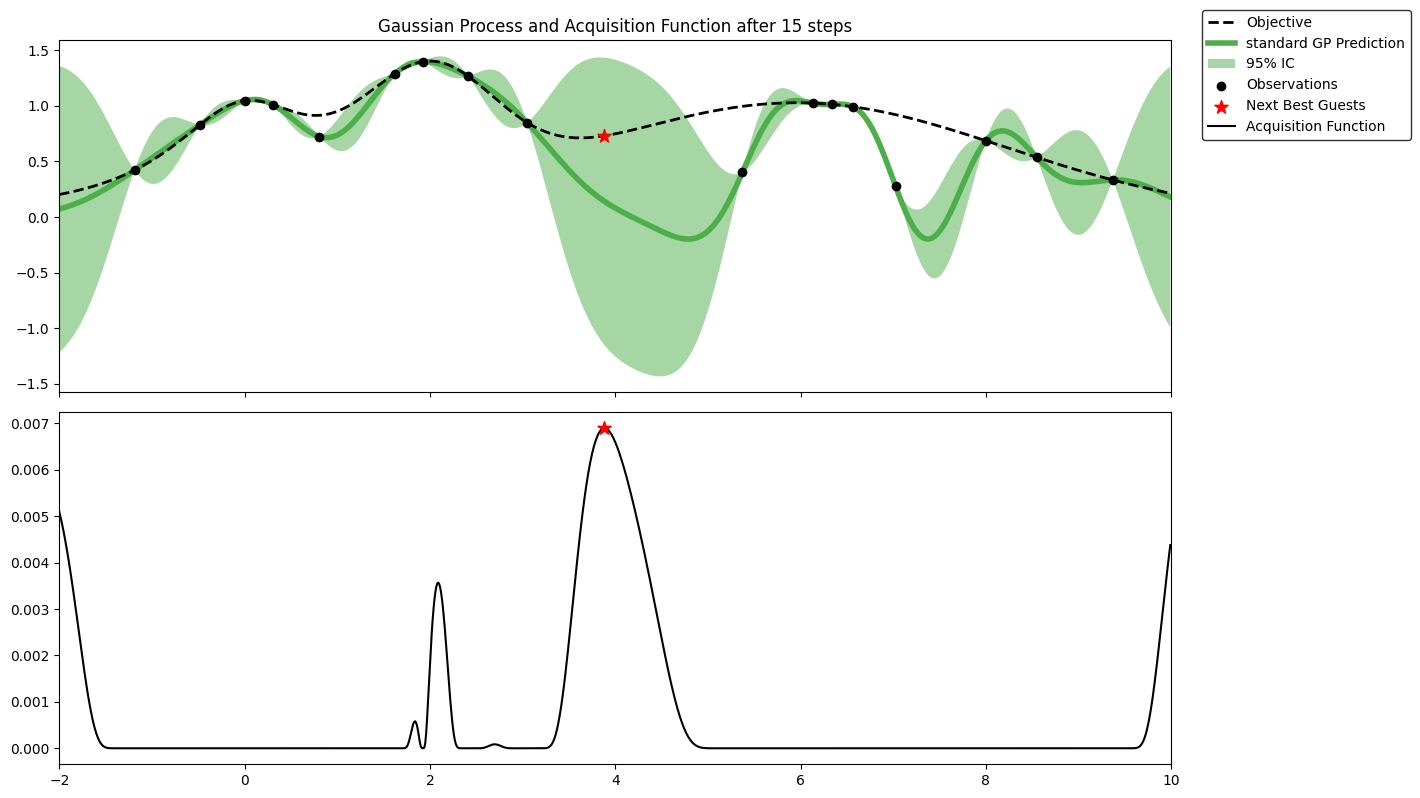

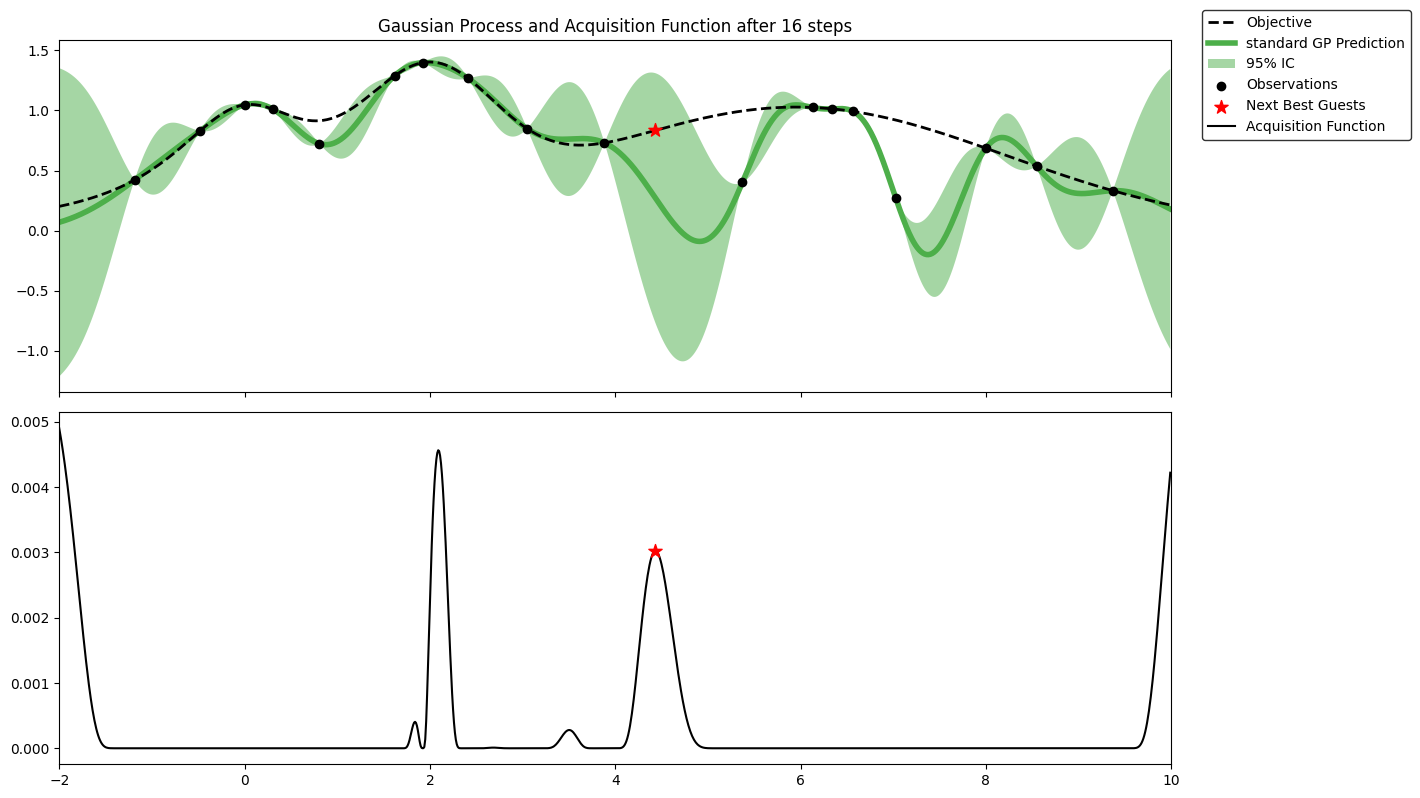

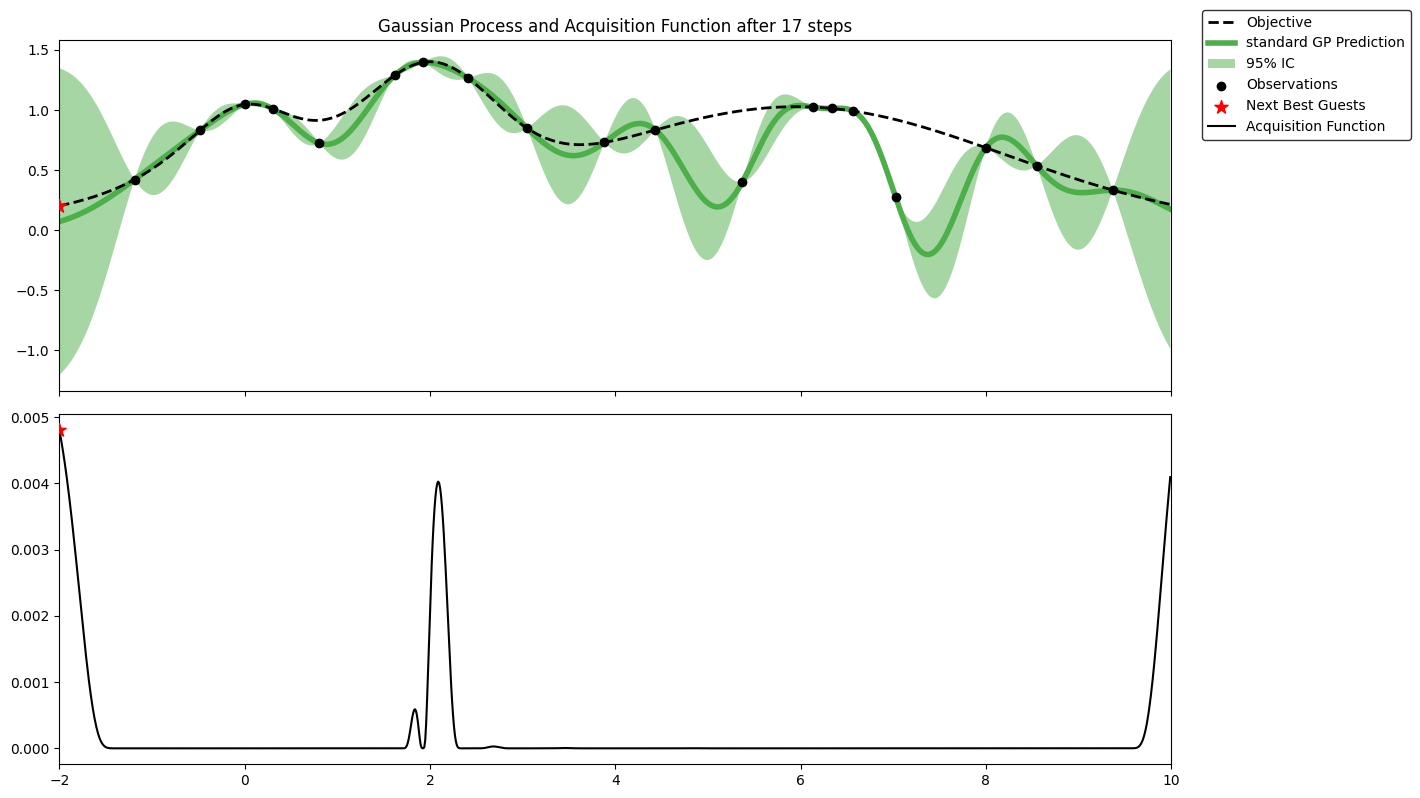

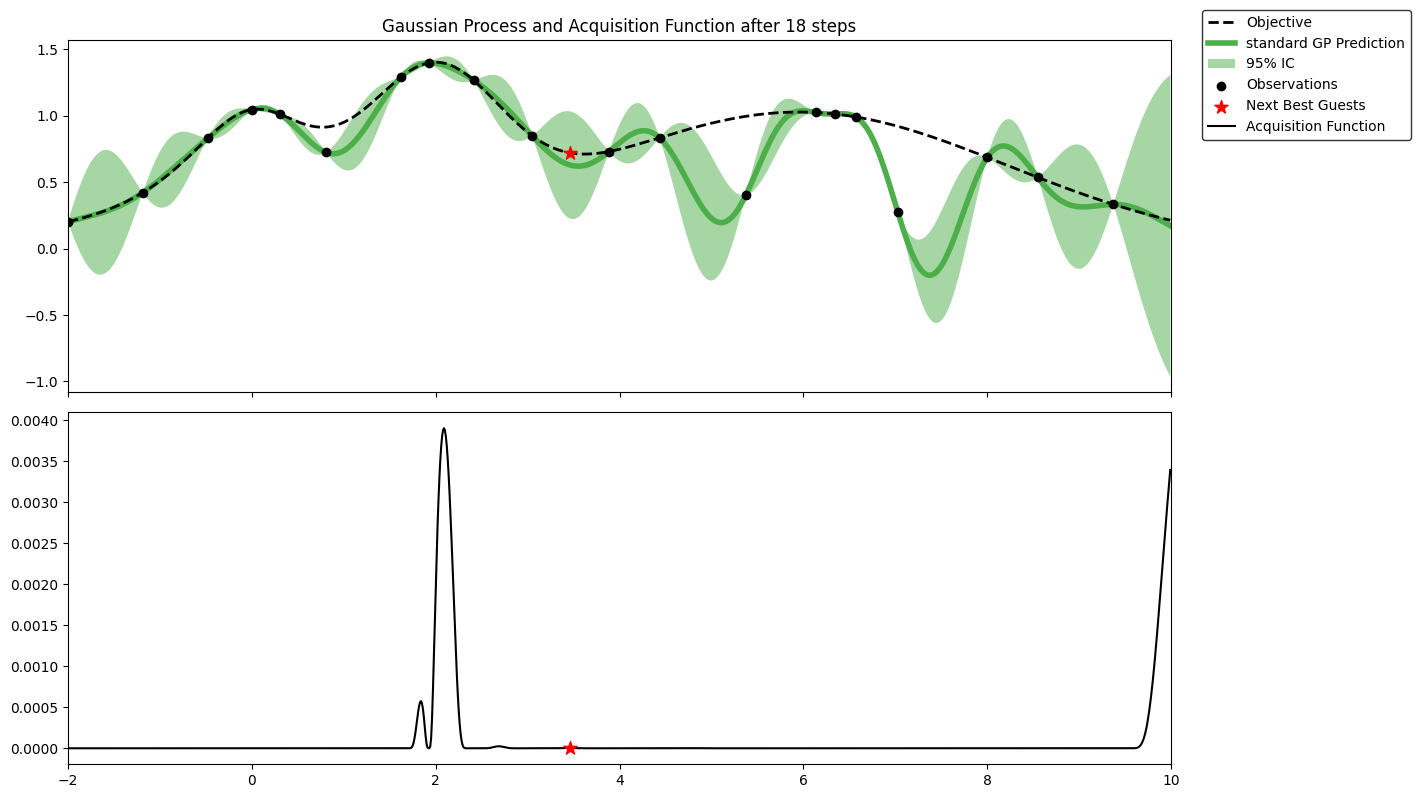

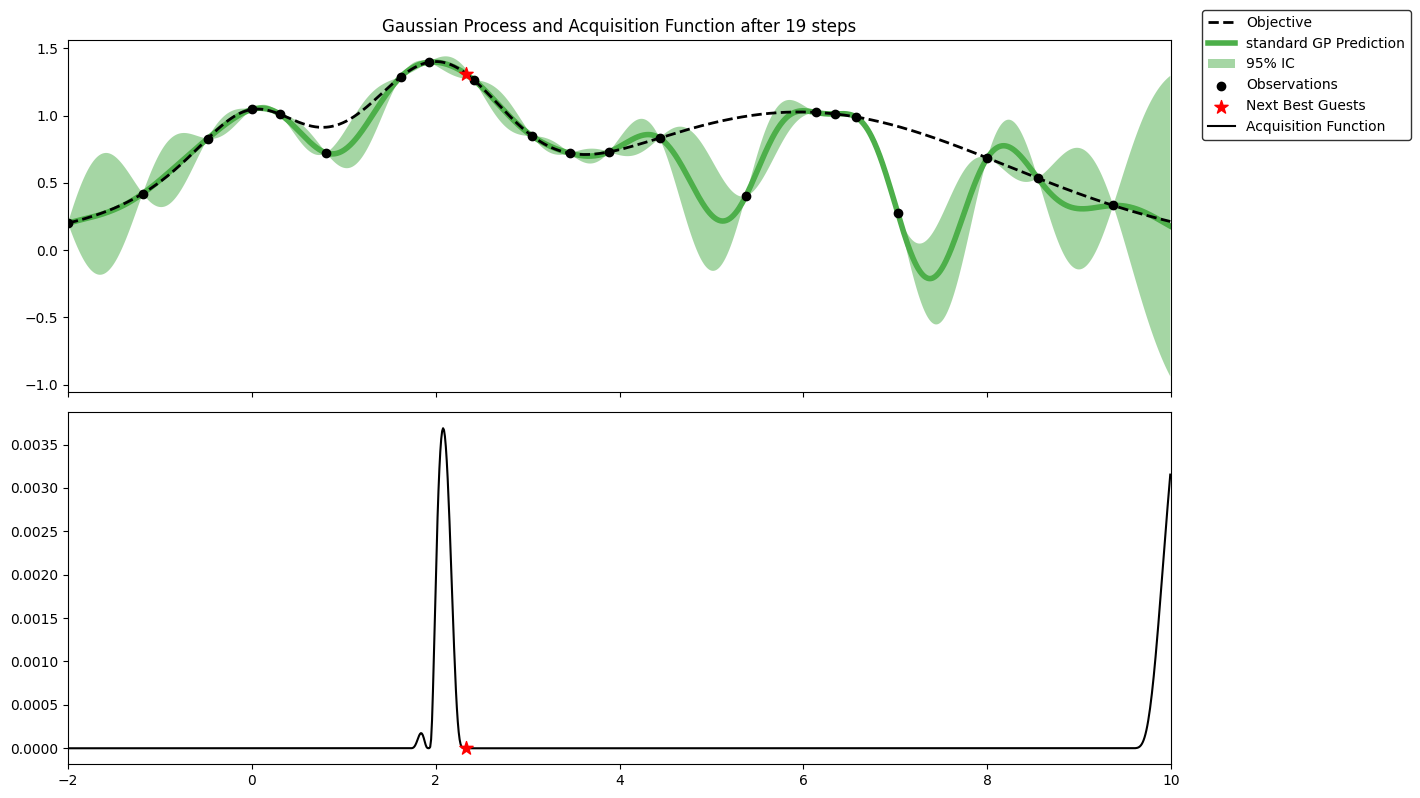

In [8]:
X_init = np.array([[0.0], [8.0]])
Y_init = f(X_init)
bo = bayesian_optimisation.BayesianOptimisation(f_outliers, 
                                                acq_function, 
                                                kernel, 
                                                gp_kind='standard', 
                                                bounds=bounds)

for i in range(n_iter):
     result = bo.optimisation(n_iter=1, X_init=X_init, Y_init=Y_init, n_restarts=25)
     plot_bo(bo, acq_function, X, Y, bounds, title='Gaussian Process and Acquisition Function after {} steps'.format(i))
     X_init = np.vstack((bo.X_sample, bo.X_next))
     Y_init = np.vstack((bo.Y_sample, bo.Y_next))

outlier


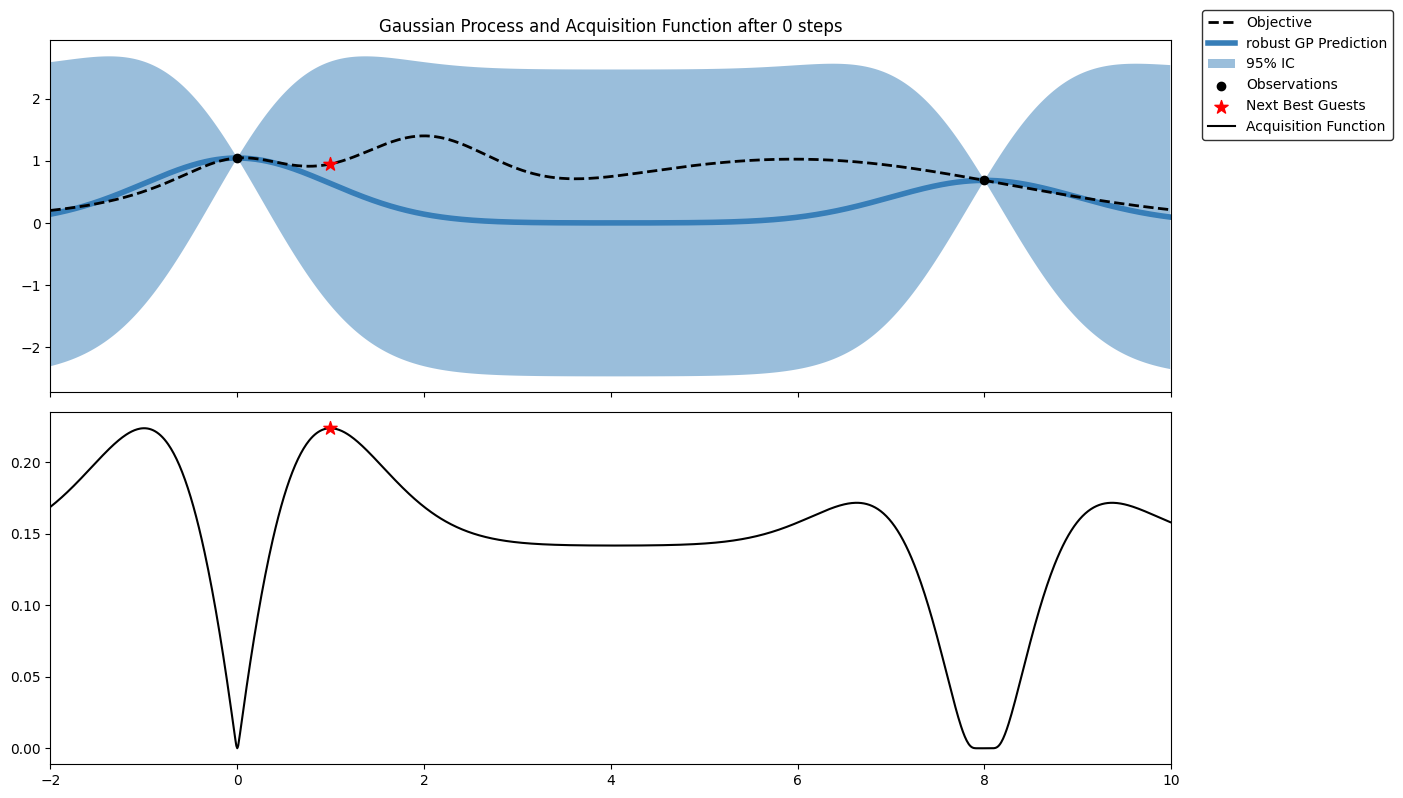

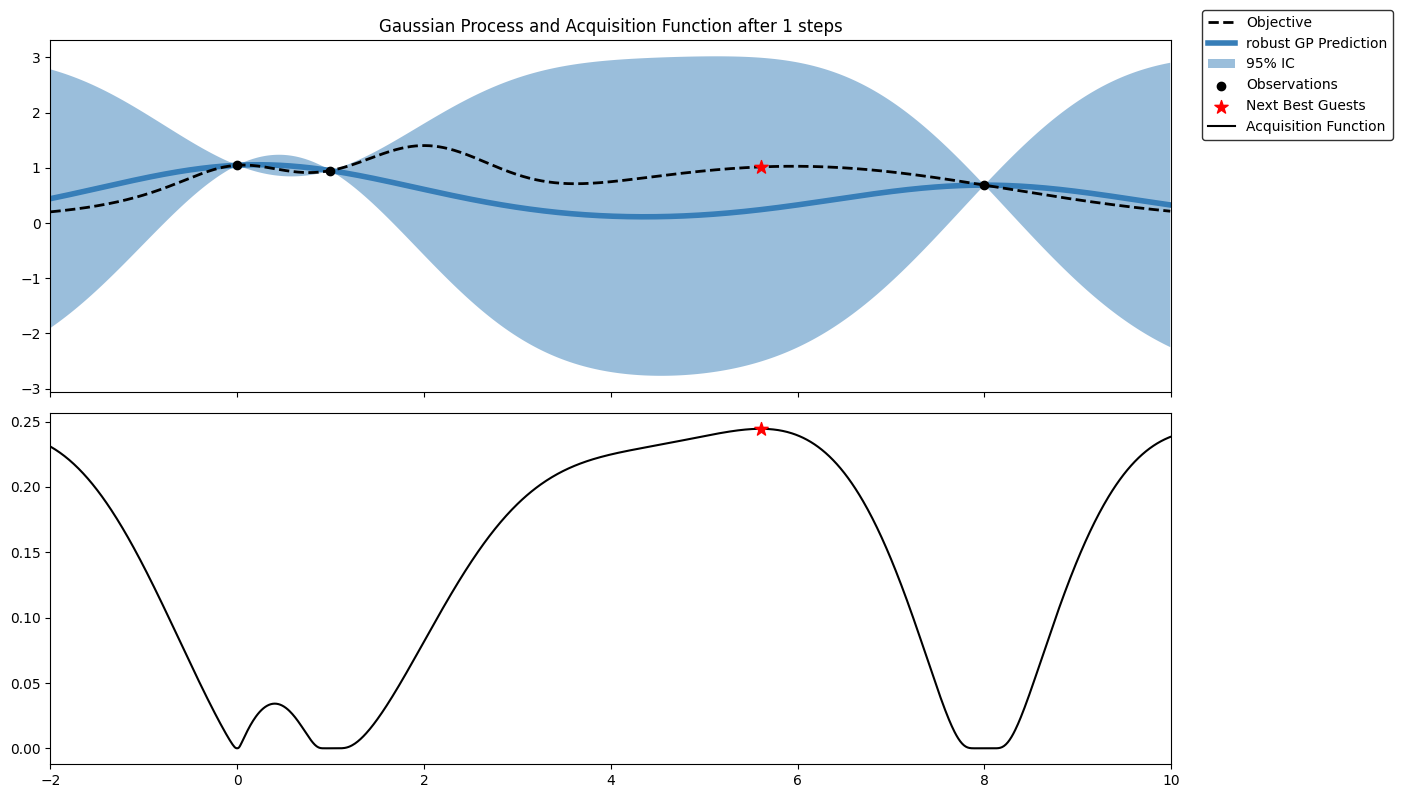

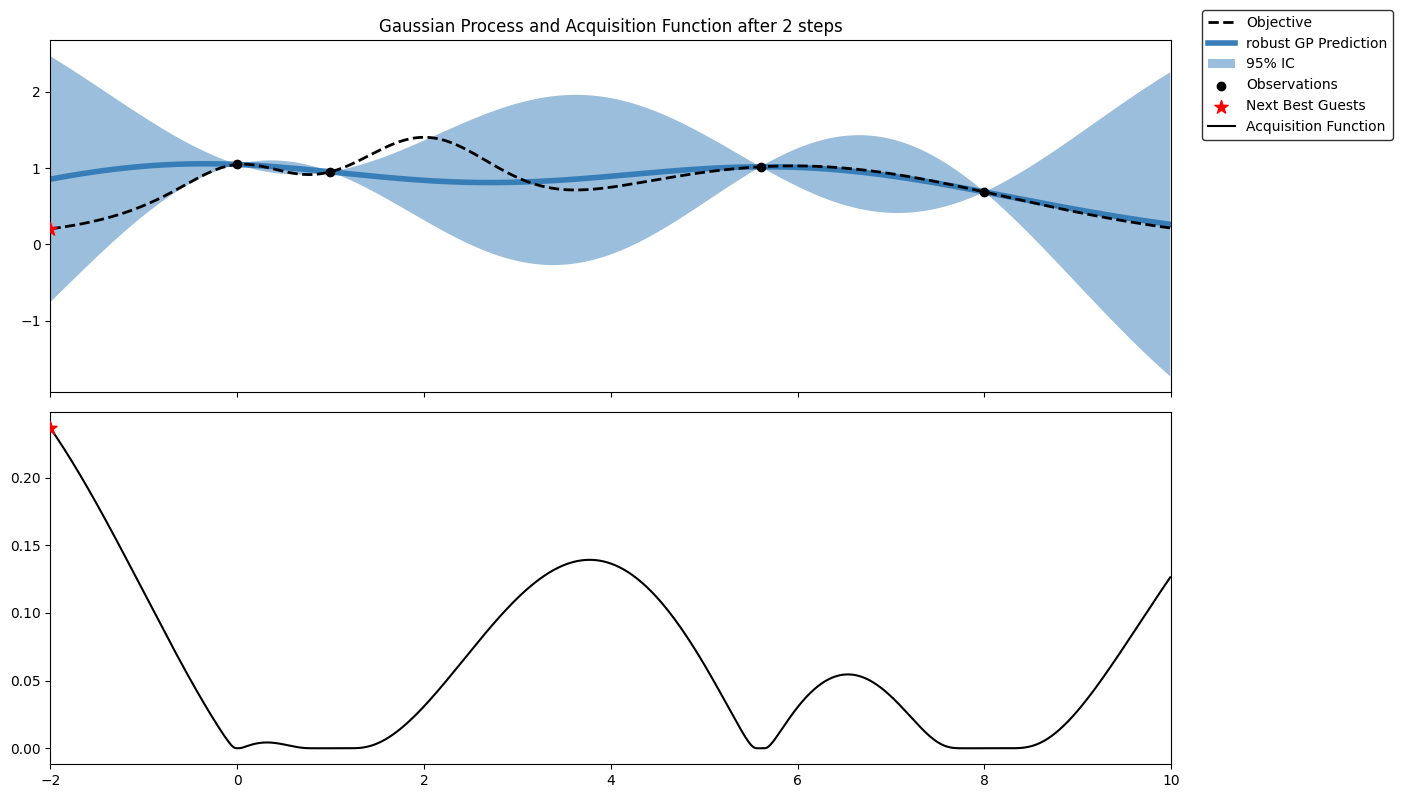

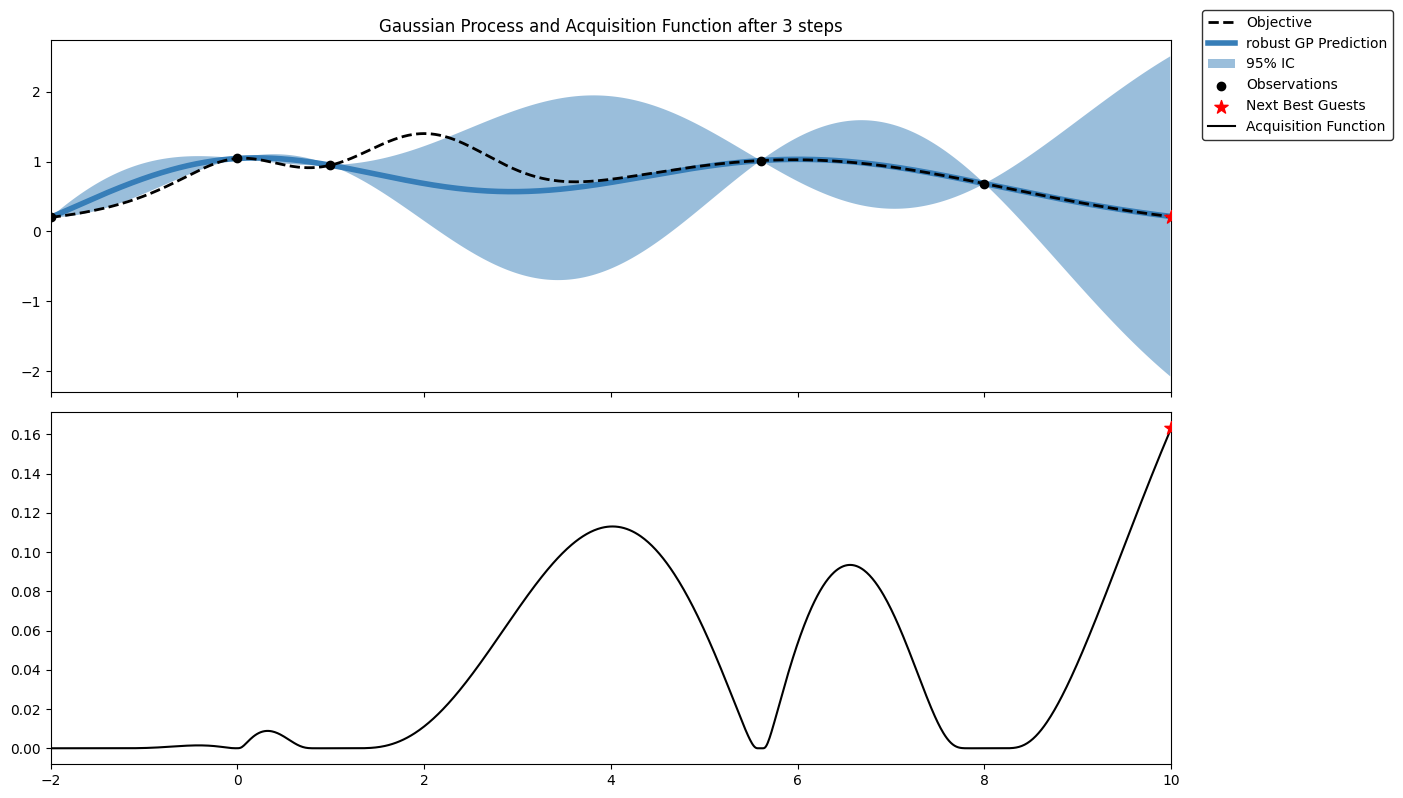

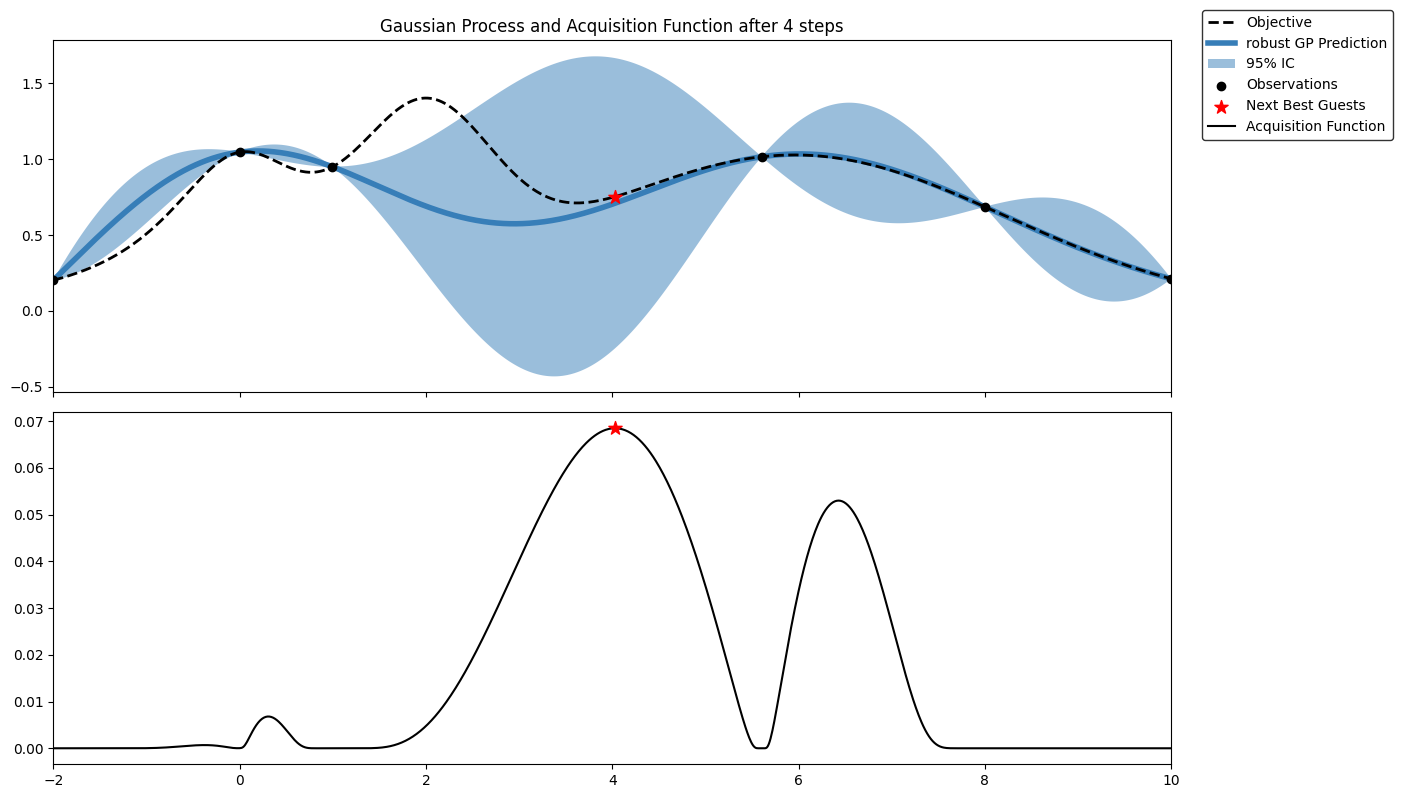

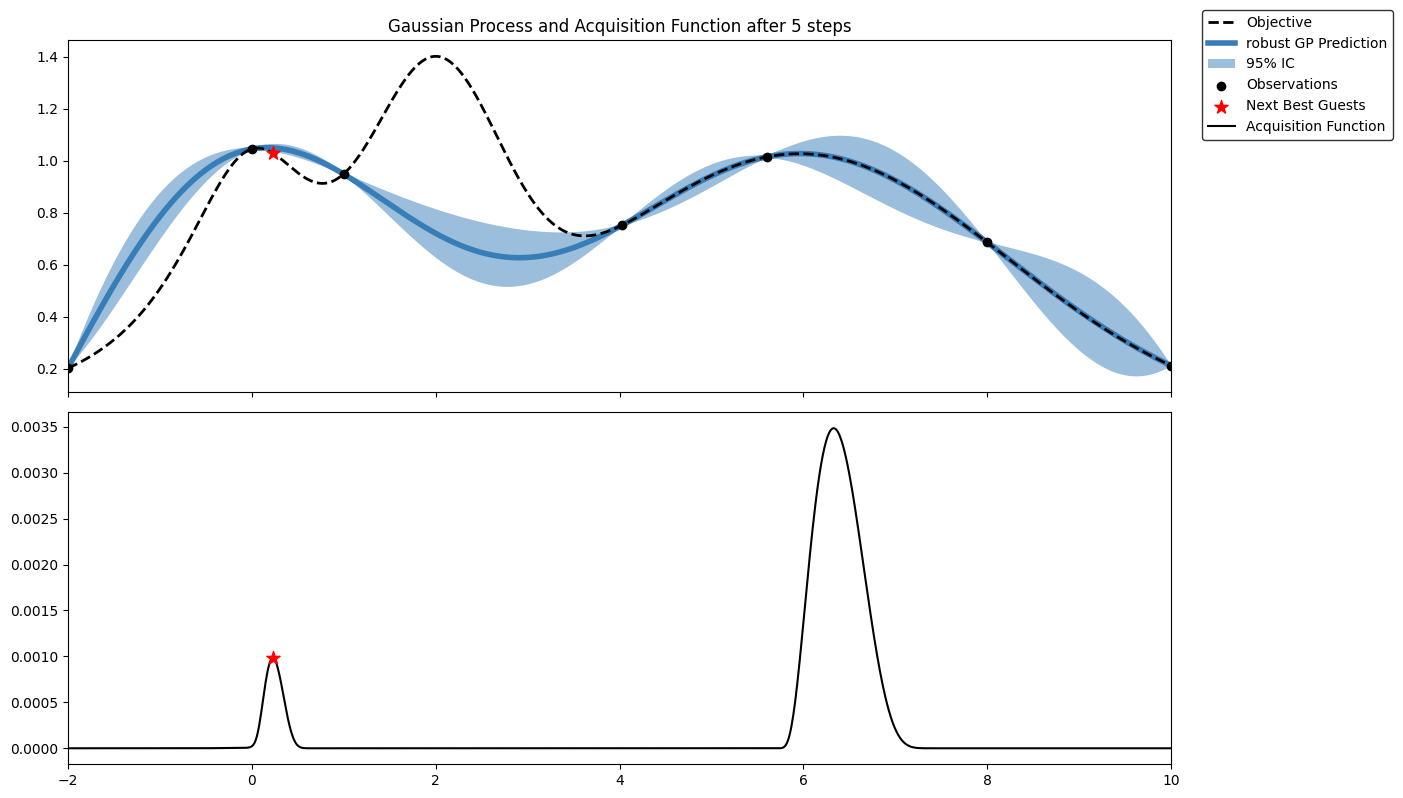

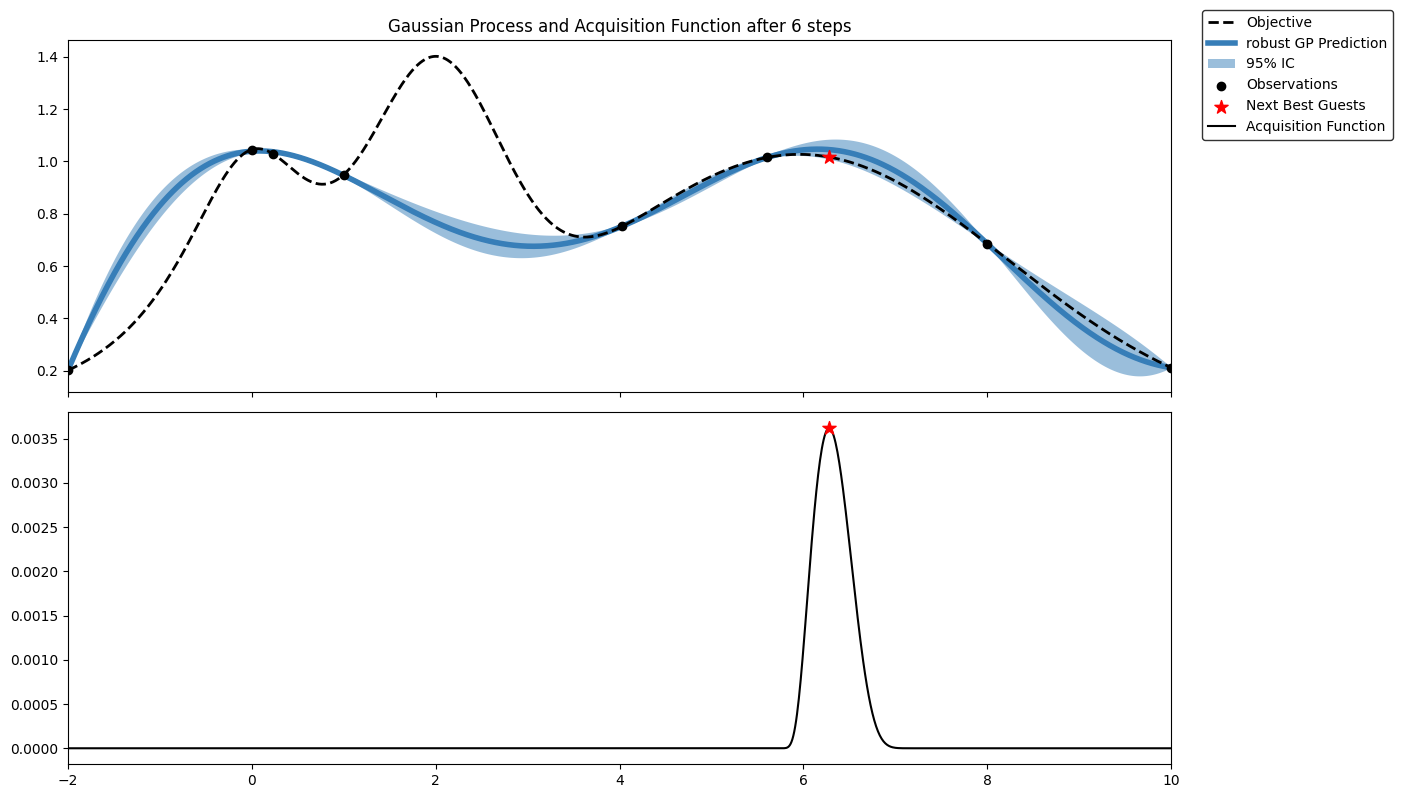

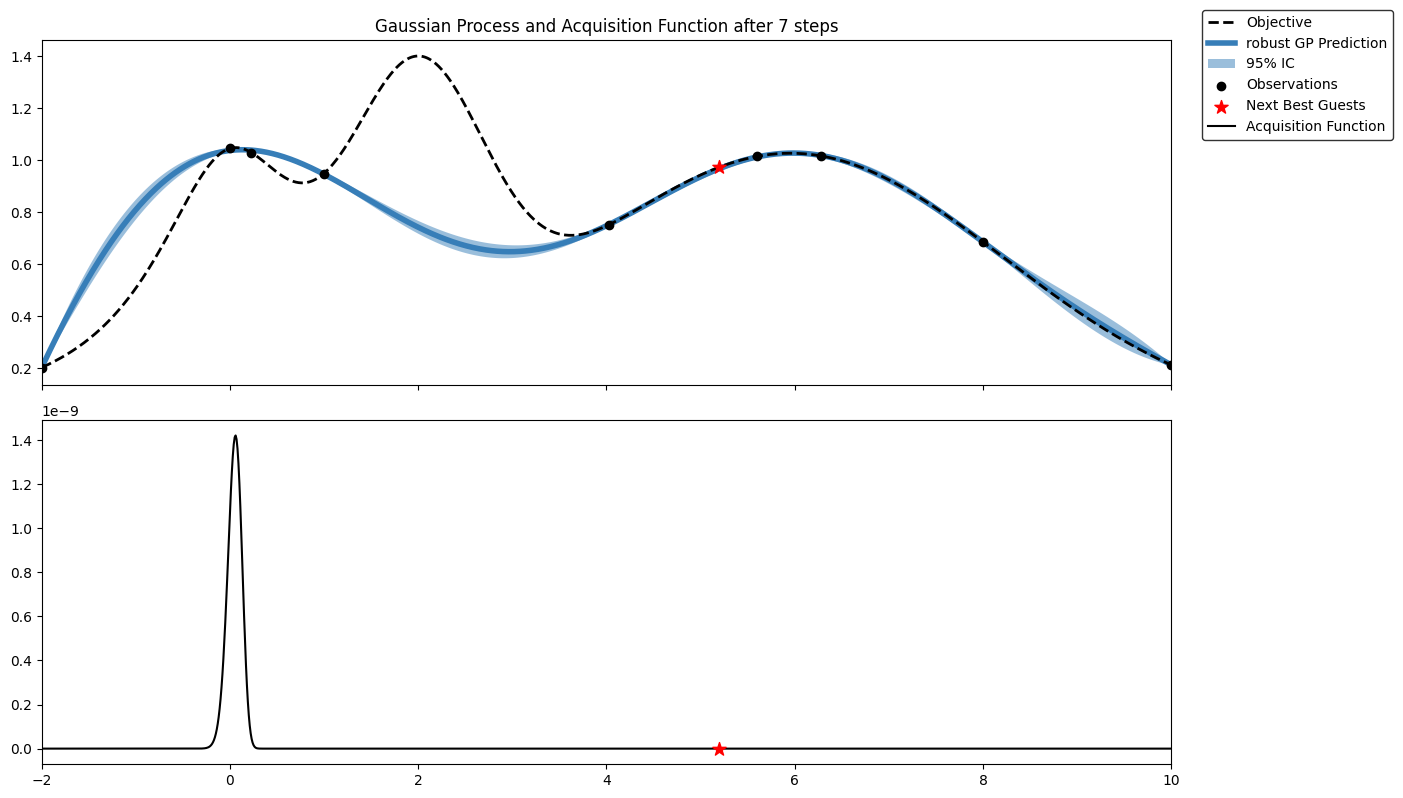

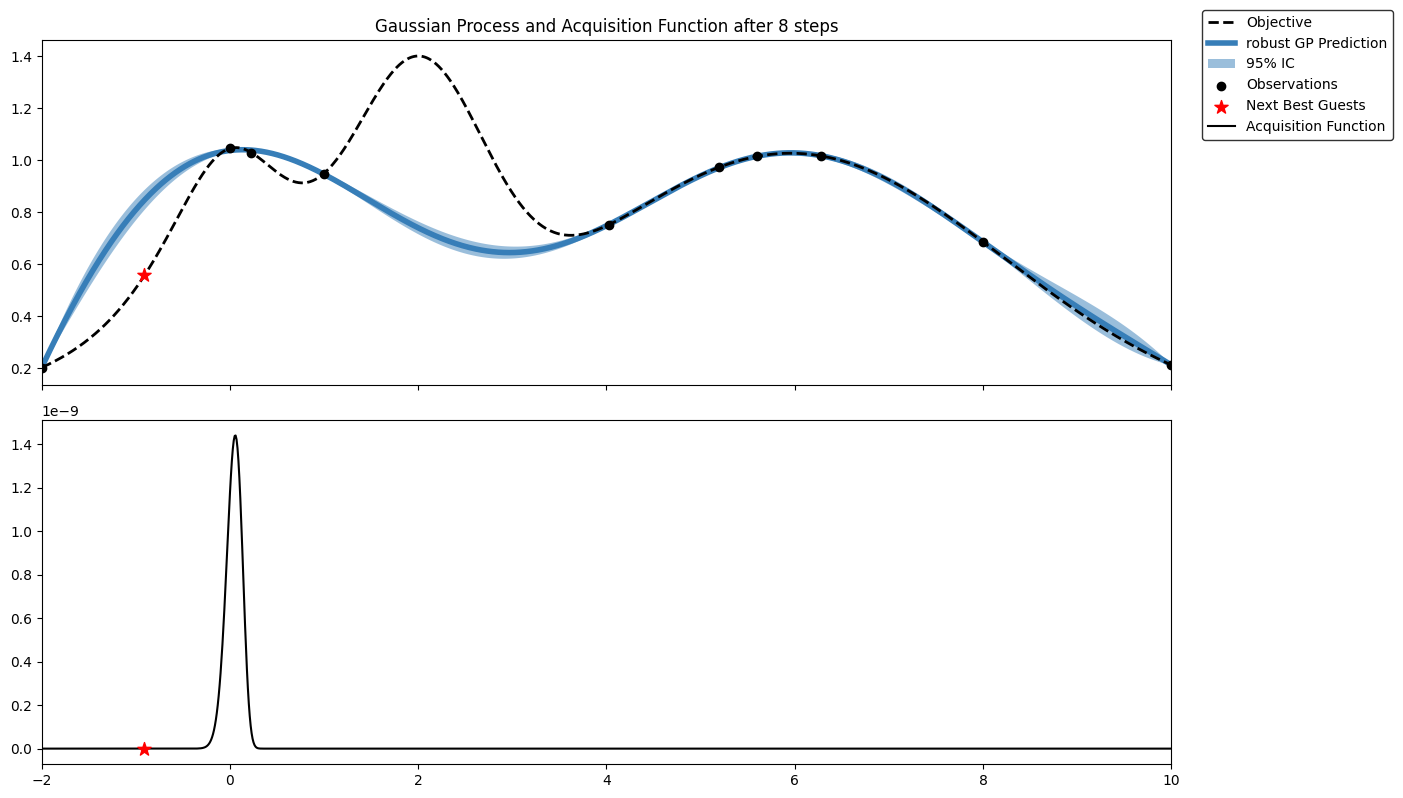

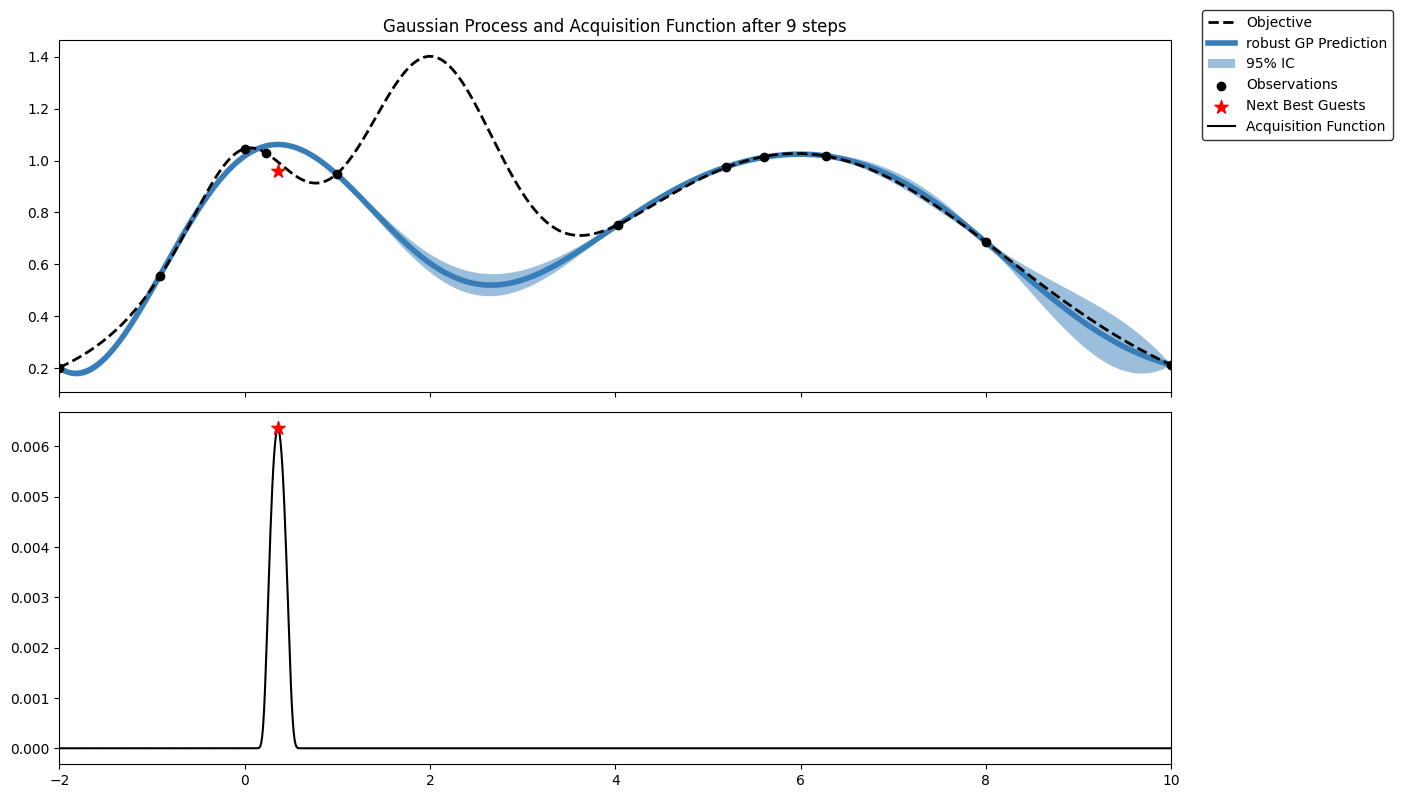

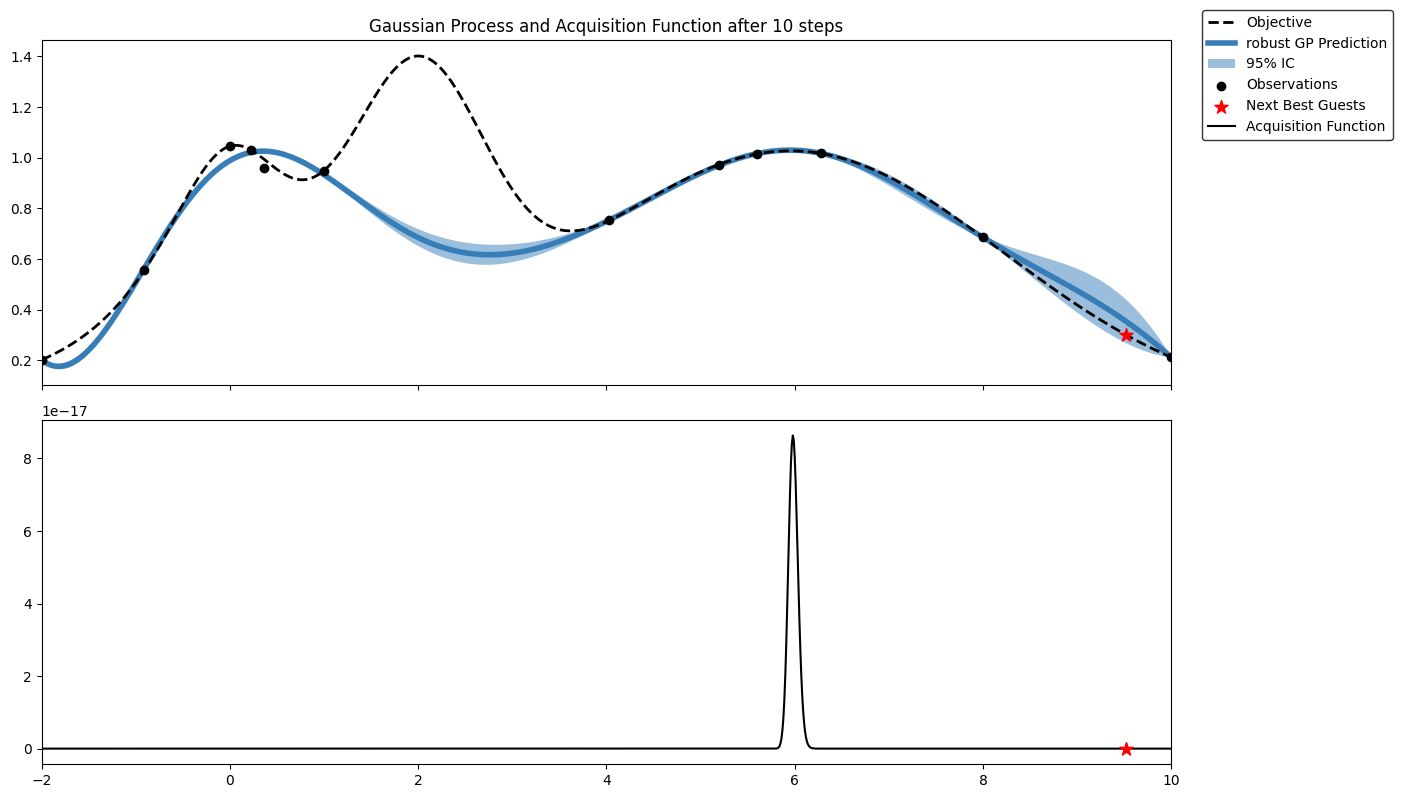

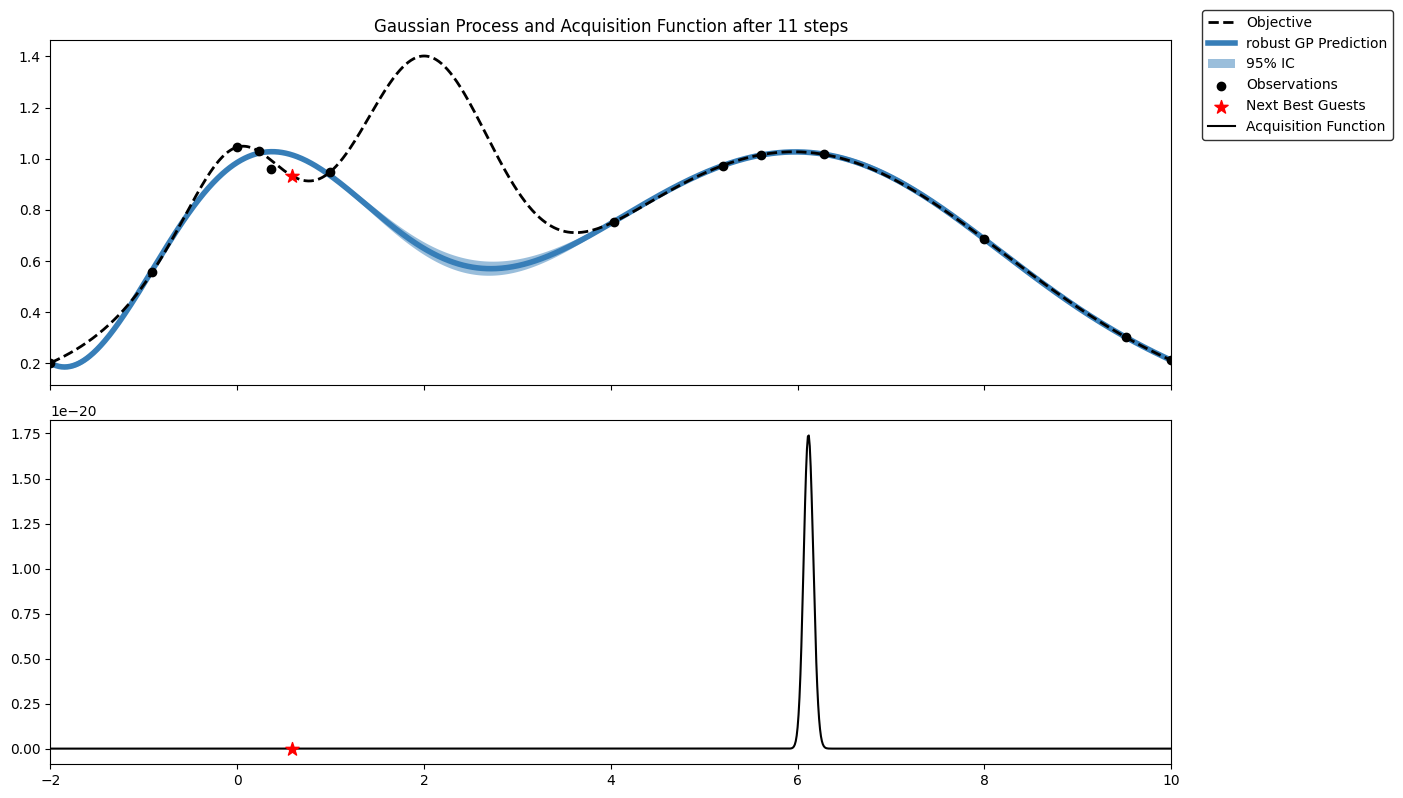

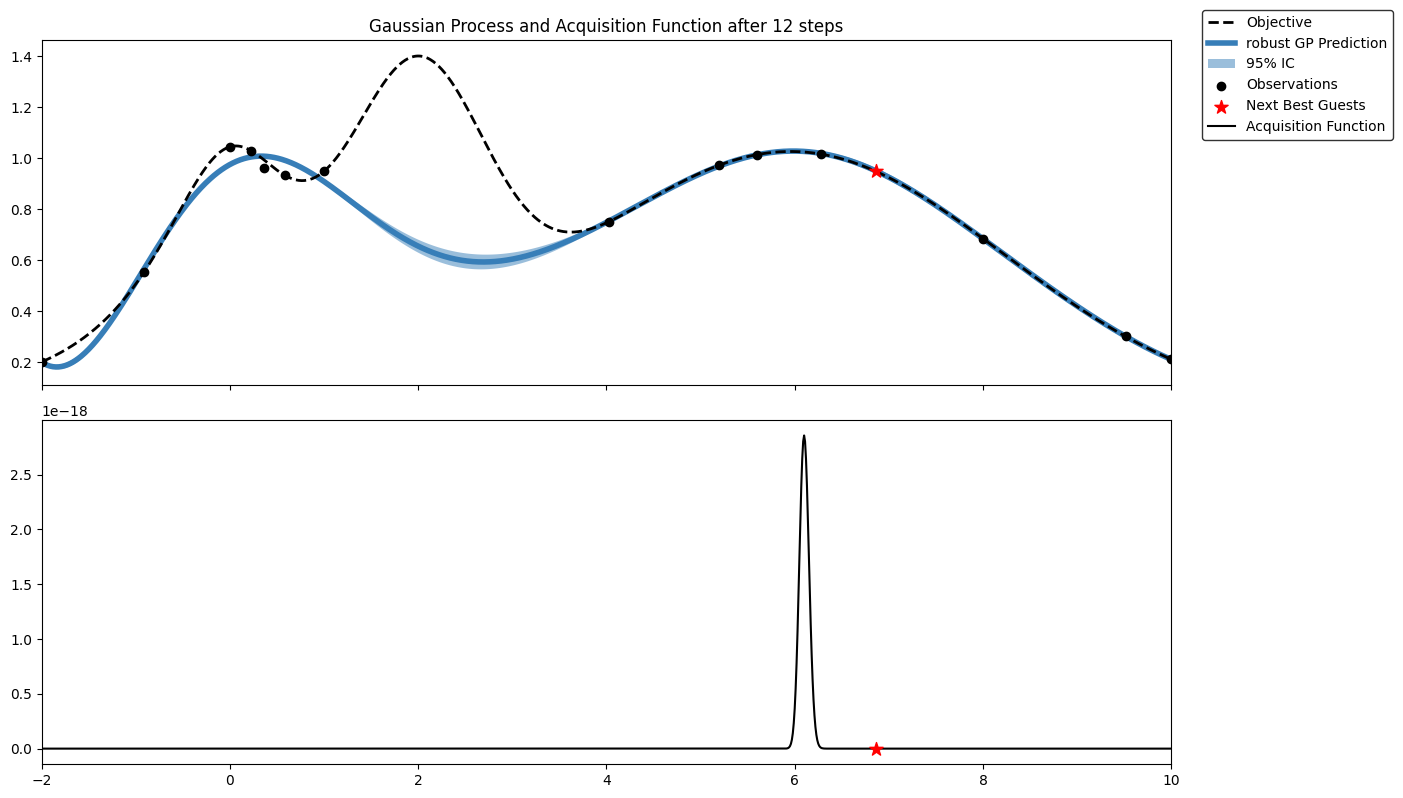

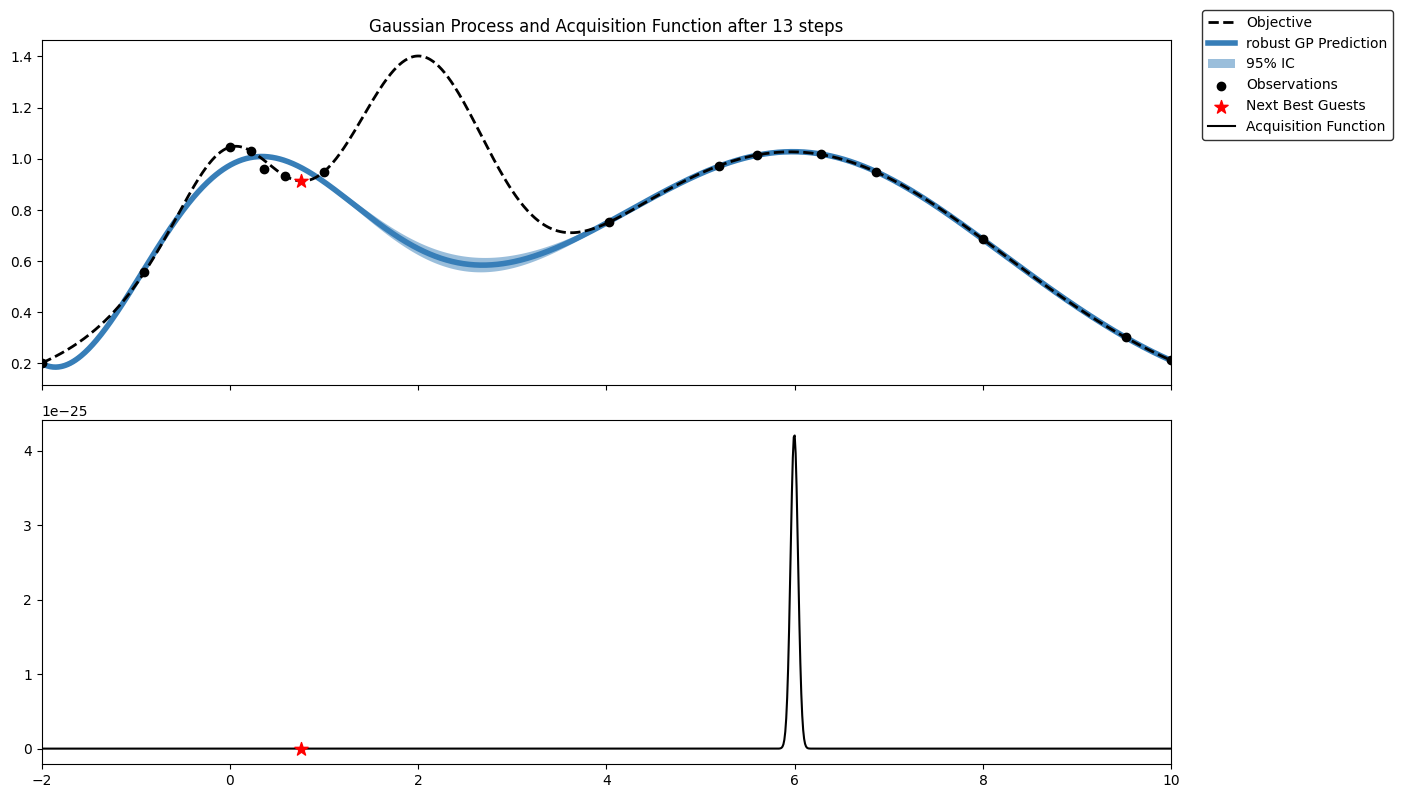

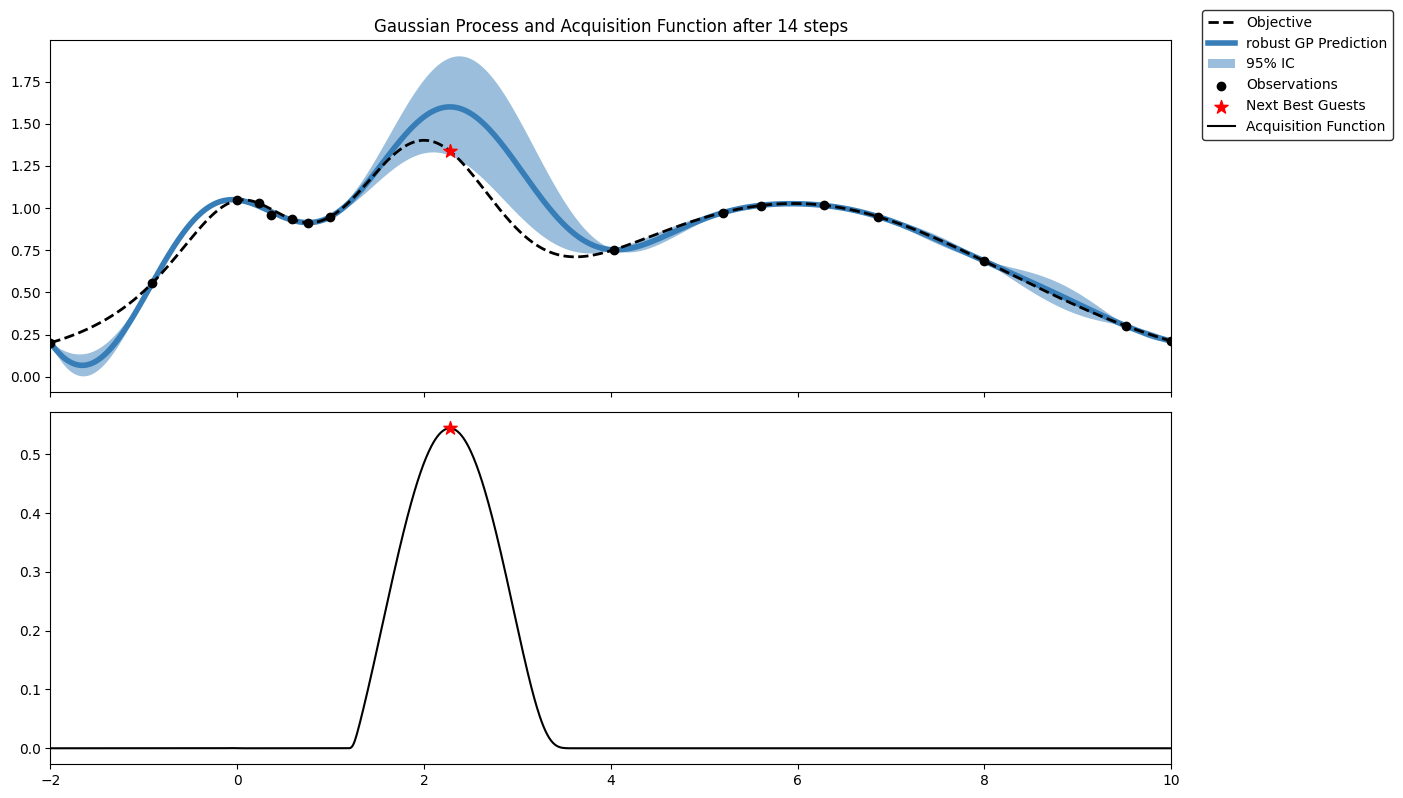

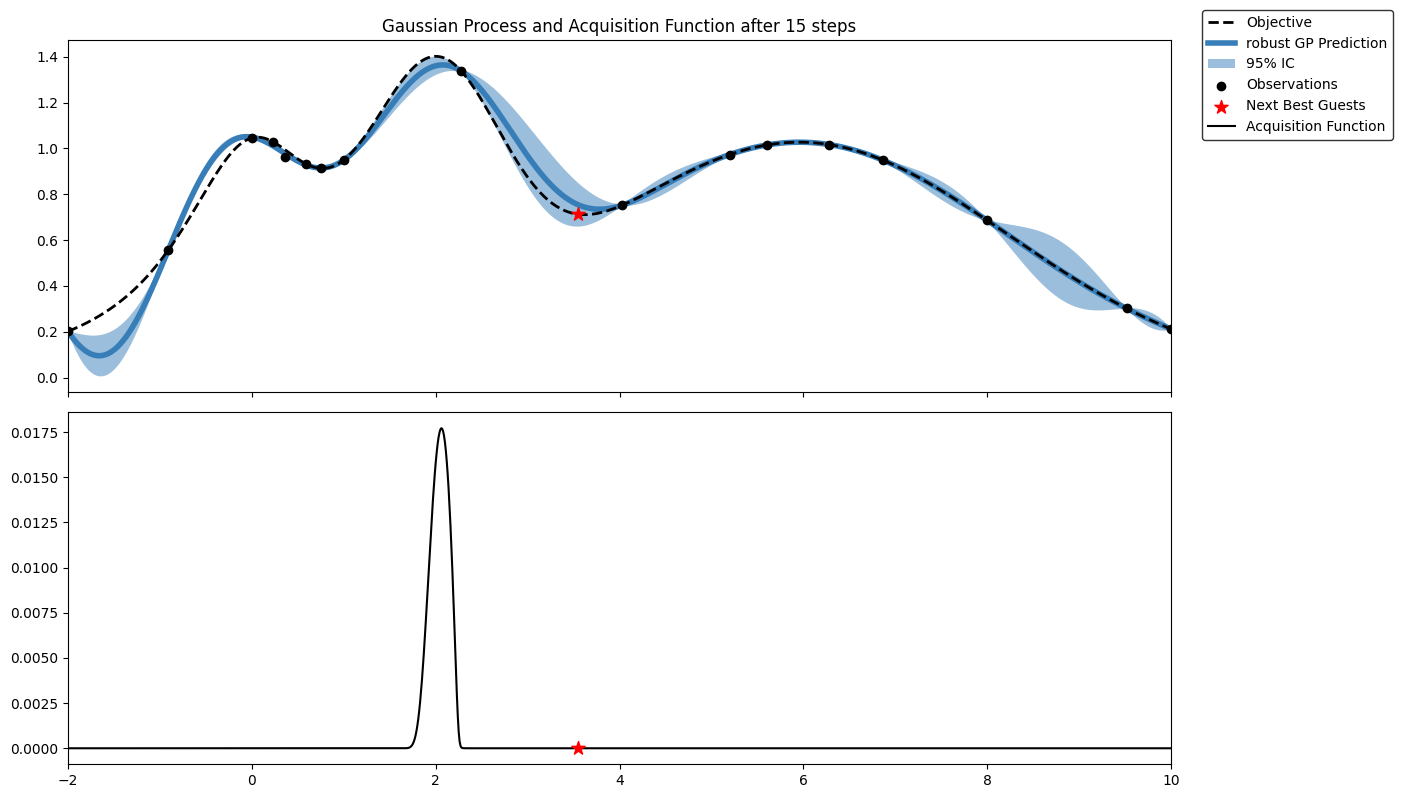

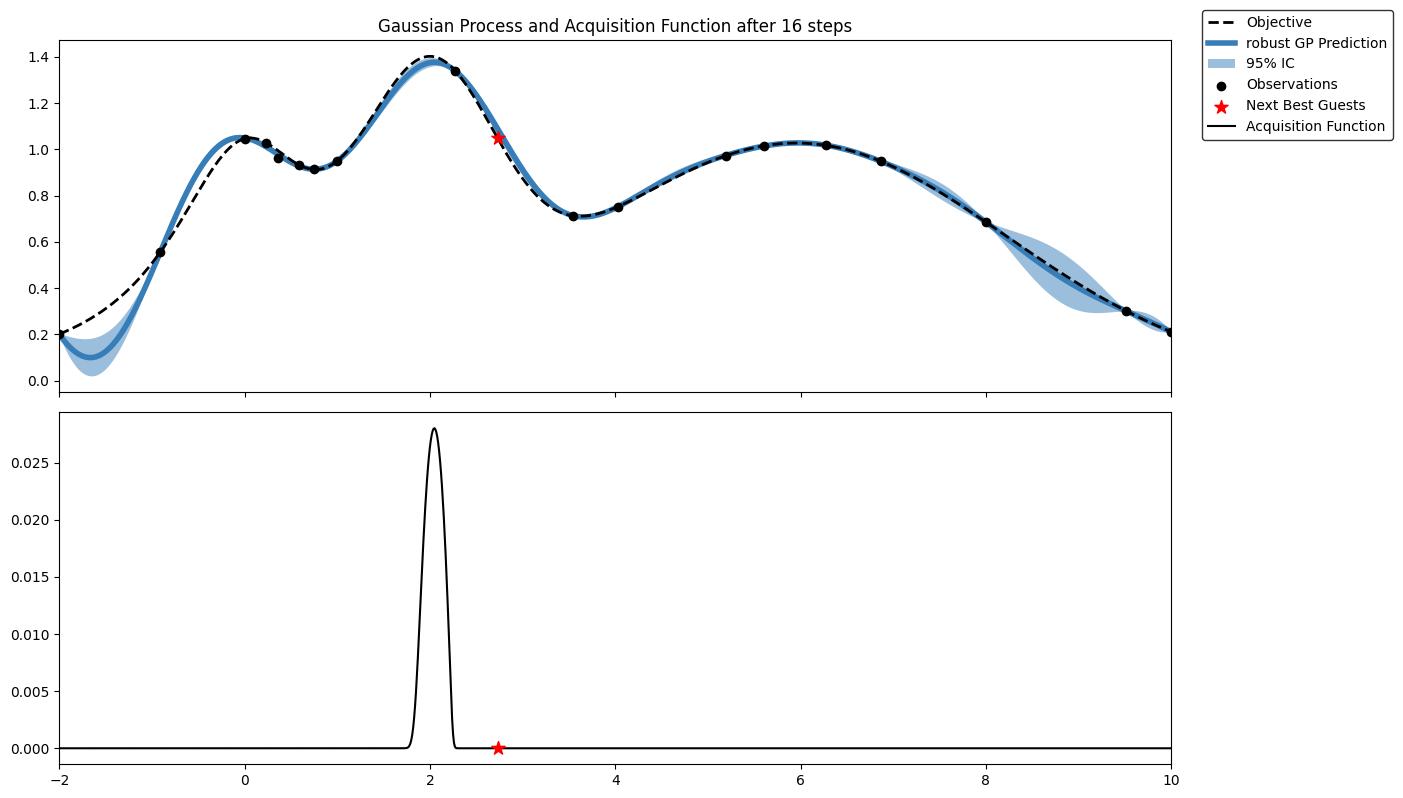

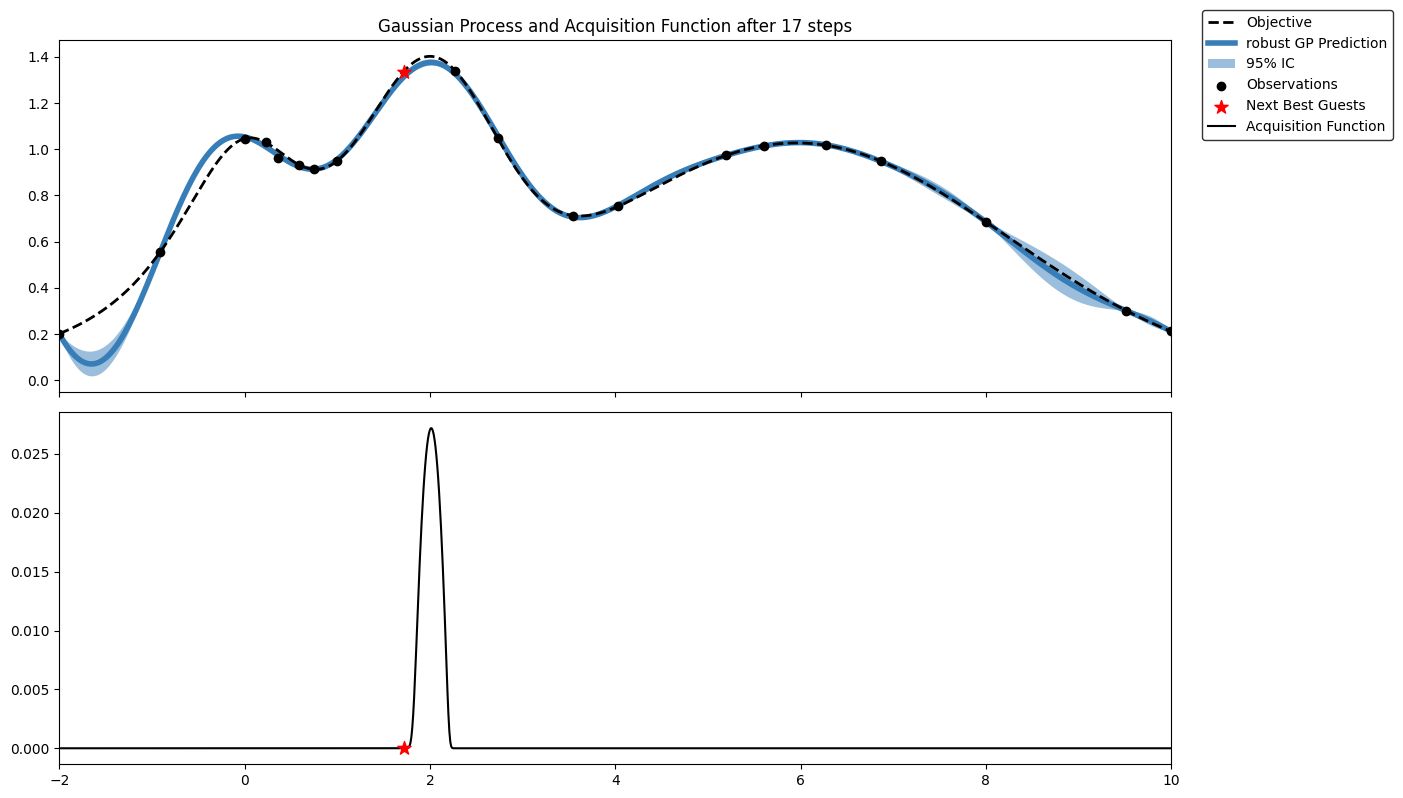

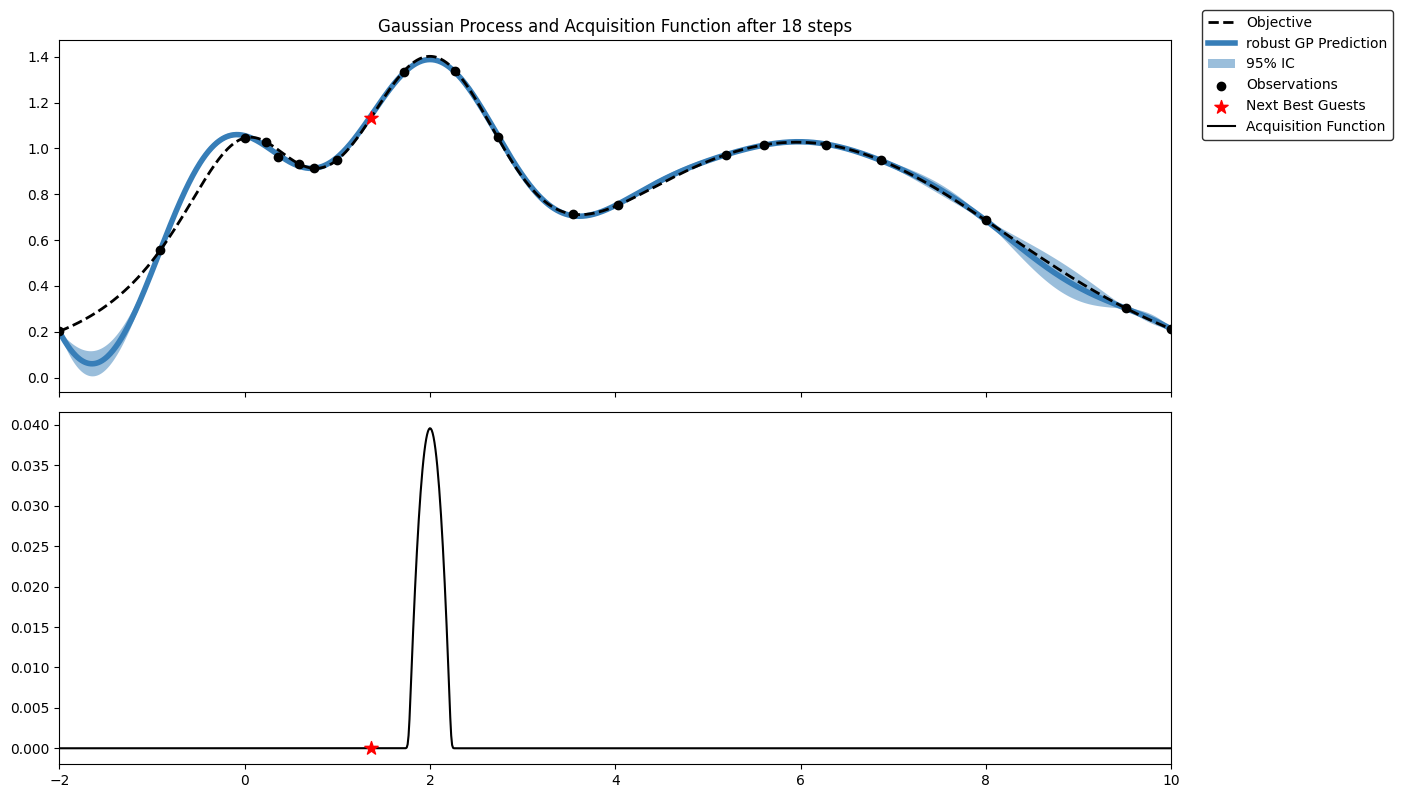

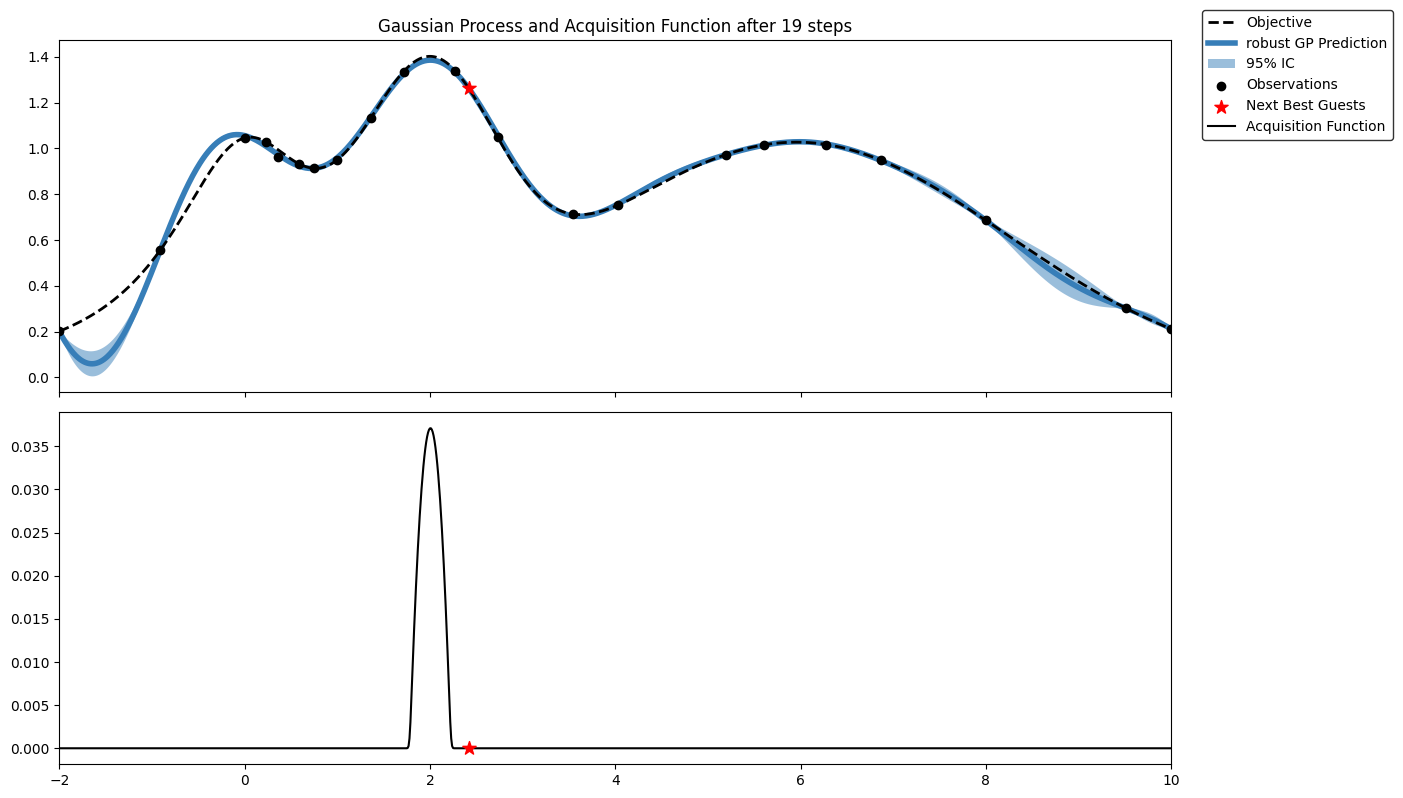

In [9]:
X_init = np.array([[0.0], [8.0]])
Y_init = f(X_init)

acq_function = bayesian_optimisation.AcquisitionFunction(kind="ei", kappa=5)
kernel = gpflow.kernels.SquaredExponential()

bo = bayesian_optimisation.BayesianOptimisation(f_outliers, 
                                                acq_function, 
                                                kernel, 
                                                gp_kind='robust', 
                                                bounds=bounds)

for i in range(n_iter):
     result = bo.optimisation(n_iter=1, X_init=X_init, Y_init=Y_init, n_restarts=5)
     plot_bo(bo, acq_function, X, Y, bounds, title='Gaussian Process and Acquisition Function after {} steps'.format(i))
     X_init = np.vstack((bo.X_sample, bo.X_next))
     Y_init = np.vstack((bo.Y_sample, bo.Y_next))